## visualDet3D

In [ ]:
cd ..
pwd

In [1]:
import sys
# sys.path.append("../")
import importlib
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import cython
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
import torchvision
from numba import jit
from tqdm import tqdm
import time

from visualDet3D.data.kitti.utils import write_result_to_file
from visualDet3D.utils.utils import LossLogger, cfg_from_file
from visualDet3D.networks.utils.registry import DETECTOR_DICT, DATASET_DICT, PIPELINE_DICT
from visualDet3D.networks.heads.anchors import Anchors
from visualDet3D.networks.lib.fast_utils.hill_climbing import post_opt
from visualDet3D.networks.utils import BBox3dProjector, BackProjection
from visualDet3D.utils.utils import convertAlpha2Rot, convertRot2Alpha, draw_3D_box, compound_annotation
import visualDet3D.data.kitti.dataset
from visualDet3D.utils.timer import Timer

print('CUDA available: {}'.format(torch.cuda.is_available()))

cfg = cfg_from_file("config/config.py")
is_test_train = True

checkpoint_name = "Stereo3D_latest.pth"

# Read Conifg File
cfg.batch_size=1
split_to_test='validation'

# Define dataset_name
is_test_train = split_to_test == 'training'
if split_to_test == 'training':
    dataset_name = cfg.data.train_dataset
elif split_to_test == 'test':
    dataset_name = cfg.data.test_dataset
else:
    dataset_name = cfg.data.val_dataset

# Make dataset
dataset = DATASET_DICT[dataset_name](
        cfg, split_to_test
        )

# Split train/validation data
if split_to_test=='training':
    dataset_val = DATASET_DICT[cfg.data.val_dataset](
            cfg, 'validation'
            )
    dataset.transform = dataset_val.transform
    dataset.collate_fn = dataset_val.collate_fn

    # Build a detector network
detector = DETECTOR_DICT[cfg.detector.name](cfg.detector)
detector = detector.cuda()

# Tensor load by GPU
weight_path = os.path.join(cfg.path.checkpoint_path, checkpoint_name)
state_dict = torch.load(weight_path, map_location='cuda:{}'.format(cfg.trainer.gpu))
new_dict = state_dict.copy()
for key in state_dict:
    if 'focalLoss' in key:
        new_dict.pop(key)

# Load the pre-trained model
detector.load_state_dict(new_dict, strict=False)
detector.eval().cuda()

# Testing pipeline
test_func = PIPELINE_DICT[cfg.trainer.test_func]

# Load projector and backprojector
projector = BBox3dProjector().cuda()
backprojector = BackProjection().cuda()

CUDA available: True


In [2]:
def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
    drawed_image = image.copy()
    for box2d in bboxes2d:
        cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
    return drawed_image

def corner_homo2bbox(corner_homo):
    """
        corner_homo: [N, 8, 3]
    """
    min_xy  = torch.min(corner_homo[:, :, 0:2], dim=1)[0]
    max_xy  = torch.max(corner_homo[:, :, 0:2], dim=1)[0]
    min_xy[:, 0]  = torch.clamp(min_xy[:, 0], 0, cfg.rgb_shape[1])
    min_xy[:, 1]  = torch.clamp(min_xy[:, 1], 0, cfg.rgb_shape[0])
    max_xy[:, 0]  = torch.clamp(max_xy[:, 0], 0, cfg.rgb_shape[1])
    max_xy[:, 1]  = torch.clamp(max_xy[:, 1], 0, cfg.rgb_shape[0])
    return torch.cat([min_xy, max_xy], dim=1)

def denorm(image):
    new_image = np.array((image * cfg.data.augmentation.rgb_std +  cfg.data.augmentation.rgb_mean) * 255, dtype=np.uint8)
    return new_image

@jit(cache=True, nopython=True)
def ToColorDepth(depth_image:np.ndarray)->np.ndarray: #[H, W] -> [H, W, 3] # Used to draw depth predictions
    H, W = depth_image.shape
    max_depth = float(np.max(depth_image))
    cmap = np.array([
        [0,0,0,114],[0,0,1,185],[1,0,0,114],[1,0,1,174], 
        [0,1,0,114],[0,1,1,185],[1,1,0,114],[1,1,1,0]
    ])
    _sum  = 0
    for i in range(8):
        _sum += cmap[i, 3]
    
    weights = np.zeros(8)
    cumsum = np.zeros(8)
    for i in range(7):
        weights[i] = _sum / cmap[i, 3]
        cumsum[i+1] = cumsum[i] + cmap[i, 3] / _sum
    
    image = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(H):
        for j in range(W):
            val = depth_image[i, j] / max_depth
            for k in range(7):
                if val <= cumsum[k + 1]:
                    break
            w = 1.0- (val - cumsum[k]) * weights[k]
            r = int( (w * cmap[k, 0] + (1 - w) * cmap[k+1, 0]) * 255 )
            g = int( (w * cmap[k, 1] + (1 - w) * cmap[k+1, 1]) * 255 )
            b = int( (w * cmap[k, 2] + (1 - w) * cmap[k+1, 2]) * 255 )
            image[i, j] = np.array([r,g,b])
    return image

In [3]:
def get_predictions(index):
    name = "%06d" % index
    data = dataset[index]
    if isinstance(data['calib'], list):
        P2 = data['calib'][0]
    else:
        P2 = data['calib']
    original_height = data['original_shape'][0]
    collated_data = dataset.collate_fn([data])
    height = collated_data[0].shape[2]
    scale_2d = (original_height - cfg.data.augmentation.crop_top) / height
    
    if len(collated_data) > 6:
        left_images, right_images, _, _, labels, bbox_3d, _ = collated_data
    else:
        left_images, right_images, _, _, labels, bbox_3d = collated_data
    image = left_images

    with torch.no_grad():
        
        left_images, right_images, P2, P3 = collated_data[0], collated_data[1], collated_data[2], collated_data[3]
        scores, bbox, obj_names = detector([left_images.cuda().float().contiguous(),
                                          right_images.cuda().float().contiguous(),
                                          P2.cuda().float(),
                                          P3.cuda().float()])
        
        P2 = P2[0]
        bbox_2d = bbox[:, 0:4]
        bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
        bbox_3d_state_3d = backprojector(bbox_3d_state, P2.cuda()) #[x, y, z, w,h ,l, alpha]
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, P2.cuda())
        
        rgb_image = denorm(image[0].cpu().numpy().transpose([1, 2, 0]))
        
        return rgb_image, scores, bbox_2d, obj_names, bbox_3d_corner_homo
    
#     if len(scores) > 0:
#         rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy())
#         for box in bbox_3d_corner_homo:
#             box = box.cpu().numpy().T
#             rgb_image = draw_3D_box(rgb_image, box)
#     if is_draw:
#         plt.imshow(np.clip(rgb_image, 0, 255))
        
#     return np.clip(rgb_image, 0, 255)

## tracking + trajectory 

In [4]:
import numpy as np
import collections

from filterpy.kalman import KalmanFilter

In [5]:
def linear_assignment(cost_matrix):
    try:
        import lap
        _, x, y = lap.lapjv(cost_matrix, extend_cost=True)
        return np.array([[y[i],i] for i in x if i >= 0]) #
    except ImportError:
        from scipy.optimize import linear_sum_assignment
        x, y = linear_sum_assignment(cost_matrix)
        return np.array(list(zip(x, y)))

def iou_batch(bb_test, bb_gt):
    """
    From SORT: Computes IOU between two bboxes in the form [x1,y1,x2,y2]
    """
    bb_gt = np.expand_dims(bb_gt, 0)
    bb_test = np.expand_dims(bb_test, 1)

    xx1 = np.maximum(bb_test[..., 0], bb_gt[..., 0])
    yy1 = np.maximum(bb_test[..., 1], bb_gt[..., 1])
    xx2 = np.minimum(bb_test[..., 2], bb_gt[..., 2])
    yy2 = np.minimum(bb_test[..., 3], bb_gt[..., 3])
    w = np.maximum(0., xx2 - xx1)
    h = np.maximum(0., yy2 - yy1)
    wh = w * h
    o = wh / ((bb_test[..., 2] - bb_test[..., 0]) * (bb_test[..., 3] - bb_test[..., 1])                                      
    + (bb_gt[..., 2] - bb_gt[..., 0]) * (bb_gt[..., 3] - bb_gt[..., 1]) - wh)                                              
    return(o)  


def convert_bbox_to_z(bbox):
    """
    Takes a bounding box in the form [x1,y1,x2,y2] and returns z in the form
    [x,y,s,r] where x,y is the centre of the box and s is the scale/area and r is
    the aspect ratio
    """
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    x = bbox[0] + w/2.
    y = bbox[1] + h/2.
    s = w * h    #scale is just area
    r = w / float(h)
    return np.array([x, y, s, r]).reshape((4, 1))

def convert_x_to_bbox(x,score=None):
    """
    Takes a bounding box in the centre form [x,y,s,r] and returns it in the form
    [x1,y1,x2,y2] where x1,y1 is the top left and x2,y2 is the bottom right
    """
    w = np.sqrt(x[2] * x[3])
    h = x[2] / w
    if(score==None):
        return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.]).reshape((1,4))
    else:
        return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.,score]).reshape((1,5))

def associate_detections_to_trackers(detections,trackers,iou_threshold = 0.3):
    """
    Assigns detections to tracked object (both represented as bounding boxes)

    Returns 3 lists of matches, unmatched_detections and unmatched_trackers
    """
    if(len(trackers)==0):
        return np.empty((0,2),dtype=int), np.arange(len(detections)), np.empty((0,5),dtype=int)

    iou_matrix = iou_batch(detections, trackers)

    if min(iou_matrix.shape) > 0:
        a = (iou_matrix > iou_threshold).astype(np.int32)
        if a.sum(1).max() == 1 and a.sum(0).max() == 1:
            matched_indices = np.stack(np.where(a), axis=1)
        else:
            matched_indices = linear_assignment(-iou_matrix)
    else:
        matched_indices = np.empty(shape=(0,2))

    unmatched_detections = []
    for d, det in enumerate(detections):
        if(d not in matched_indices[:,0]):
            unmatched_detections.append(d)
    unmatched_trackers = []
    for t, trk in enumerate(trackers):
        if(t not in matched_indices[:,1]):
            unmatched_trackers.append(t)

    #filter out matched with low IOU
    matches = []
    for m in matched_indices:
        if(iou_matrix[m[0], m[1]]<iou_threshold):
            unmatched_detections.append(m[0])
            unmatched_trackers.append(m[1])
        else:
            matches.append(m.reshape(1,2))
    if(len(matches)==0):
        matches = np.empty((0,2),dtype=int)
    else:
        matches = np.concatenate(matches,axis=0)

    return matches, np.array(unmatched_detections), np.array(unmatched_trackers)

In [6]:
class KalmanBoxTracker(object):
    """
    This class represents the internal state of individual tracked objects observed as bbox.
    """
    count = 0
    def __init__(self,bbox,no_of_past_frames=5,no_of_future_frames=5):
        """
        Initialises a tracker using initial bounding box.
        """
        #define constant velocity model
        self.kf = KalmanFilter(dim_x=7, dim_z=4) 
        self.kf.F = np.array([[1,0,0,0,1,0,0],[0,1,0,0,0,1,0],[0,0,1,0,0,0,1],[0,0,0,1,0,0,0],  [0,0,0,0,1,0,0],[0,0,0,0,0,1,0],[0,0,0,0,0,0,1]])
        self.kf.H = np.array([[1,0,0,0,0,0,0],[0,1,0,0,0,0,0],[0,0,1,0,0,0,0],[0,0,0,1,0,0,0]])

        self.kf.R[2:,2:] *= 10.
        self.kf.P[4:,4:] *= 1000. #give high uncertainty to the unobservable initial velocities
        self.kf.P *= 10.
        self.kf.Q[-1,-1] *= 0.01
        self.kf.Q[4:,4:] *= 0.01

        self.kf.x[:4] = convert_bbox_to_z(bbox)
        self.time_since_update = 0
        self.id = KalmanBoxTracker.count
        KalmanBoxTracker.count += 1
        self.history = []

        self.no_of_past_frames = no_of_past_frames
        self.no_of_future_frames = no_of_future_frames
        self.update_history = collections.deque(maxlen=self.no_of_past_frames)
        self.predict_history = collections.deque(maxlen=self.no_of_future_frames)

        self.hits = 0
        self.hit_streak = 0
        self.age = 0

    def update(self,bbox):
        """
        Updates the state vector with observed bbox.
        """
        self.time_since_update = 0
        self.history = []
        self.hits += 1
        self.hit_streak += 1
        self.kf.update(convert_bbox_to_z(bbox))
        self.update_history.append(bbox)

        if  len(self.update_history)>=self.no_of_past_frames :
            kbt = KalmanBoxTrajectory(self.update_history[0])
            for j in range(1,self.no_of_past_frames):
                kbt.predict()
                p = kbt.update(self.update_history[j])
            for k in range(self.no_of_future_frames):
                p = kbt.predict()[0]
                self.predict_history.append(p)


    def predict(self):
        """
        Advances the state vector and returns the predicted bounding box estimate.
        """
        if((self.kf.x[6]+self.kf.x[2])<=0):
          self.kf.x[6] *= 0.0
        self.kf.predict()
        self.age += 1
        if(self.time_since_update>0):
          self.hit_streak = 0
        self.time_since_update += 1
        self.history.append(convert_x_to_bbox(self.kf.x))
        return self.history[-1]

    def get_state(self):
        """
        Returns the current bounding box estimate.
        """
        return convert_x_to_bbox(self.kf.x)

    def get_future_predictions(self):
        """
        Returns the future bounding box estimate.
        """
        return np.array(self.predict_history)
    

In [7]:
class KalmanBoxTrajectory(object):
  """
  This class represents the internal state of individual tracked objects observed as bbox.
  """
  count = 0
  def __init__(self,bbox):
    """
    Initialises a tracker using initial bounding box.
    """
    #define constant velocity model
    self.kf = KalmanFilter(dim_x=7, dim_z=4) 
    self.kf.F = np.array([[1,0,0,0,1,0,0],[0,1,0,0,0,1,0],[0,0,1,0,0,0,1],[0,0,0,1,0,0,0],  [0,0,0,0,1,0,0],[0,0,0,0,0,1,0],[0,0,0,0,0,0,1]])
    self.kf.H = np.array([[1,0,0,0,0,0,0],[0,1,0,0,0,0,0],[0,0,1,0,0,0,0],[0,0,0,1,0,0,0]])

    self.kf.R[2:,2:] *= 10.
    self.kf.P[4:,4:] *= 1000. #give high uncertainty to the unobservable initial velocities
    self.kf.P *= 10.
    self.kf.Q[-1,-1] *= 0.01
    self.kf.Q[4:,4:] *= 0.01

    self.kf.x[:4] = convert_bbox_to_z(bbox)
    self.id = KalmanBoxTrajectory.count
    KalmanBoxTrajectory.count += 1
    self.history = []

  def update(self,bbox):
    """
    Updates the state vector with observed bbox.
    """
    self.history = []
    self.kf.update(convert_bbox_to_z(bbox))    

  def predict(self):
    """
    Advances the state vector and returns the predicted bounding box estimate.
    """
    if((self.kf.x[6]+self.kf.x[2])<=0):
      self.kf.x[6] *= 0.0
    self.kf.predict()
    self.history.append(convert_x_to_bbox(self.kf.x))
    return self.history[-1]

  def get_state(self):
    """
    Returns the current bounding box estimate.
    """
    return convert_x_to_bbox(self.kf.x)

In [8]:
#trajectory class
class Trajectory(object):
  def __init__(self, max_age=1, min_hits=3, iou_threshold=0.3, no_of_future_frames=5, no_of_past_frames=5):
    """
    Sets key parameters for Trajectory
    """
    self.max_age = max_age
    self.min_hits = min_hits
    self.iou_threshold = iou_threshold
    self.trackers = []
    self.frame_count = 0

    self.no_of_future_frames = no_of_future_frames
    self.no_of_past_frames = no_of_past_frames


  def update(self, dets=np.empty((0, 5))):
    """
    Params:
      dets - a numpy array of detections in the format [[x1,y1,x2,y2,score],[x1,y1,x2,y2,score],...]
    Requires: this method must be called once for each frame even with empty detections (use np.empty((0, 5)) for frames without detections).
    Returns the a similar array, where the last column is the object ID.

    NOTE: The number of objects returned may differ from the number of detections provided.
    """
    self.frame_count += 1
    # get predicted locations from existing trackers.
    trks = np.zeros((len(self.trackers), 5))
    to_del = []
    ret = []
    for t, trk in enumerate(trks):
      pos = self.trackers[t].predict()[0]
      trk[:] = [pos[0], pos[1], pos[2], pos[3], 0]
      if np.any(np.isnan(pos)):
        to_del.append(t)
    trks = np.ma.compress_rows(np.ma.masked_invalid(trks))
    for t in reversed(to_del):
      self.trackers.pop(t)
    matched, unmatched_dets, unmatched_trks = associate_detections_to_trackers(dets,trks, self.iou_threshold)

    # update matched trackers with assigned detections
    for m in matched:
      self.trackers[m[1]].update(dets[m[0], :])

    # create and initialise new trackers for unmatched detections
    for i in unmatched_dets:
        trk = KalmanBoxTracker(dets[i,:],self.no_of_past_frames,self.no_of_future_frames)
        self.trackers.append(trk)
    i = len(self.trackers)
    for trk in reversed(self.trackers):
        d = trk.get_state()[0] #current bounding box position
        fp = trk.get_future_predictions() #future predictions
        if (trk.time_since_update < 1) and (trk.hit_streak >= self.min_hits or self.frame_count <= self.min_hits):
          ret.append([d,fp, trk.id]) 
        i -= 1
        # remove dead tracklet
        if(trk.time_since_update > self.max_age):
          self.trackers.pop(i)
    if(len(ret)>0):
      return np.array(ret)
    return np.empty((0,5))

## trajectory testing

In [9]:
from IPython.display import clear_output

In [10]:
#create instance of Trajectory
mot_tracker = Trajectory() 

In [11]:
rgb_image, scores, bbox_2d, obj_names, bbox_3d_corner_homo=get_predictions(0)


/home/theekshana/Documents/visualDet3D/visualDet3D/data/kitti/dataset/stereo_dataset.py:155: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525553989/work/torch/csrc/utils/tensor_new.cpp:230.)
  return torch.from_numpy(left_images).float(), torch.from_numpy(right_images).float(), torch.tensor(P2).float(), torch.tensor(P3).float(), label, bbox2ds, bbox3ds
/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


PSM Cos Volume takes 0.0107574462890625 seconds at call time 1


/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


In [12]:
print(bbox_2d)
print(bbox_3d_corner_homo)

tensor([[362.5341,  88.2979, 501.7556, 177.1234],
        [710.6368,  91.8519, 831.3434, 194.3847],
        [482.2452,  83.0200, 548.6132, 131.7629],
        [  0.0000,  95.0049, 215.5065, 223.0947],
        [610.1448,  81.6984, 643.2297, 110.3696],
        [297.8843,  81.3750, 401.9554, 140.6441],
        [652.6979,  81.8962, 679.8235, 105.2977]], device='cuda:0')
tensor([[[ 460.5521,   90.2801,    1.0000],
         [ 364.2825,   90.2800,    1.0000],
         [ 364.2825,  176.6544,    1.0000],
         [ 426.0219,  155.1623,    1.0000],
         [ 426.0219,   88.8248,    1.0000],
         [ 499.9596,   88.8249,    1.0000],
         [ 499.9596,  155.1631,    1.0000],
         [ 460.5521,  176.6557,    1.0000]],

        [[ 829.1939,   95.4327,    1.0000],
         [ 718.1041,   95.2374,    1.0000],
         [ 718.1041,  192.1027,    1.0000],
         [ 717.7762,  165.7129,    1.0000],
         [ 717.7762,   92.4957,    1.0000],
         [ 801.3859,   92.6068,    1.0000],
         [ 801

tensor([362.5341,  88.2979, 501.7556, 177.1234])


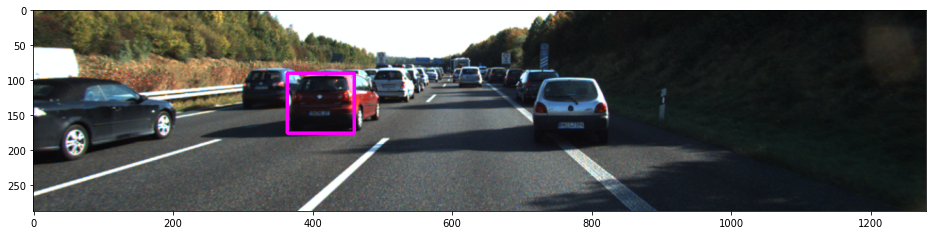

In [13]:
rgb_image_c=rgb_image.copy()
coords_2d = bbox_2d[0].cpu()
coords_3d = bbox_3d_corner_homo[0].cpu()
print(coords_2d)
# x1,y1,x2,y2=int(coords_2d[0]),int(coords_2d[1]),int(coords_2d[2]),int(coords_2d[3])
x1,y1 = int(coords_3d[0][0]), int(coords_3d[0][1])
x2,y2 = int(coords_3d[2][0]), int(coords_3d[2][1])
color=(255, 0, 255)
cv2.rectangle(rgb_image_c, (x1,y1),(x2,y2), color, 3)
# if len(scores) > 0:
#         rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy())
#         for box in bbox_3d_corner_homo:
#             box = box.cpu().numpy().T
#             rgb_image = draw_3D_box(rgb_image, box)
# box = coords_3d.cpu().numpy().T
# rgb_image = draw_3D_box(rgb_image, box)
fig = plt.figure(figsize=(16,9))
plt.imshow(np.clip(rgb_image_c, 0, 255))
plt.show()

In [21]:
def assignTrackID(index):
    # get detections
    rgb_image, scores, bbox_2d, obj_names, bbox_3d_corner_homo=get_predictions(index)
    
    if len(scores) > 0:
        
        """
            NOTE: In 3D bbox_3d_corner_homo 0,1,2,7 are the coordinates of the front face of the 3D bounding box
        """
        
        
        detectionsList=[]
        for i in range(len(scores)):
            #for 2d bounding box
#             detection=np.append((bbox_2d[i]).cpu(),scores[i].cpu())
            
            #for 3D bounding box converting to 2D
            coords_3d = bbox_3d_corner_homo[i].cpu()
            x1,y1 = coords_3d[1][0], coords_3d[1][1]
            x2,y2 = coords_3d[7][0], coords_3d[7][1]
            bb=[x1,y1,x2,y2]
            detection=np.append(bb,scores[i].cpu())
            
            detectionsList.append(detection)
        detectionsNumPyArray = np.asarray(detectionsList)
#         print('-------detectionsNumPyArray-------\n',detectionsNumPyArray)
#         print('-------type detectionsNumPyArray-------\n',type(detectionsNumPyArray))
#         print('-------detectionsNumPyArray 0-------\n',detectionsNumPyArray[0])
        # update SORT
        #  def update(self, dets=np.empty((0, 5))):
        """
            Params:
              dets - a numpy array of detections in the format [[x1,y1,x2,y2,score],[x1,y1,x2,y2,score],...]
            Requires: this method must be called once for each frame even with empty detections (use np.empty((0, 5)) for frames without detections).
            Returns the a similar array, where the last column is the object ID.

            NOTE: The number of objects returned may differ from the number of detections provided.
        """
        track_bbs_ids_list = mot_tracker.update(detectionsNumPyArray)
#         print('-------track_bbs_ids_list-------\n',track_bbs_ids_list)
    # track_bbs_ids is a np array where each row contains a valid bounding box and track_id (last column)

        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)

        track_bbs_ids_list=track_bbs_ids_list.tolist()
        
        for track_bbs_ids in track_bbs_ids_list:
            coords = track_bbs_ids[0]
            x1,y1,x2,y2=int(coords[0]),int(coords[1]),int(coords[2]),int(coords[3])
            trackID=int(track_bbs_ids[-1])
            name="ID: {}".format(str(trackID))

            # font
            font = cv2.FONT_HERSHEY_SIMPLEX
            # org
            org = (x1, y1-10)
            # fontScale
            fontScale = 0.9
            # Line thickness of 2 px
            thickness = 2
            # Blue color in BGR
            color=(0, 255, 255)
            text_color_bg=(0, 0, 0)
            text_size, _ = cv2.getTextSize(name, font, fontScale, thickness)
            text_w, text_h = text_size
            cv2.rectangle(rgb_image, (x1 , y1-10 - text_h), (x1 + text_w, y1-10), text_color_bg, -1)
            
            # Using cv2.putText() method
            cv2.putText(rgb_image,name, org, font, fontScale, color, thickness, cv2.LINE_AA)

                
# def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
#     drawed_image = image.copy()
#     for box2d in bboxes2d:
#         cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
#     return drawed_image
            
    return np.clip(rgb_image, 0, 255), track_bbs_ids_list

In [26]:
imagei,track_bbs_ids=assignTrackID(1)
# print(track_bbs_ids)
for bbs in track_bbs_ids: #for each vehicle in a image frame
    bb=bbs[0] #current bounding box
    future_bb=bbs[1] #future bounding boxes
    vehicle_id=bbs[-1] #vehicle id
    print('bb coords',bb)
    print('trackID',bbs[-1])
    print('future coords',future_bb,'\n')

/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


bb coords [655.11366384  81.81785932 679.16270496 104.68258092]
trackID 88
future coords [[656.16721236  81.9428346  680.30667177 104.95421489]
 [656.88288858  82.04575347 681.07863412 105.11078954]
 [657.59863011  82.14873461 681.85053115 105.26730193]
 [658.31443651  82.25177758 682.62236332 105.42375249]
 [659.03030732  82.35488195 683.39413107 105.58014164]] 

bb coords [479.36934427  83.12555067 532.80609458 134.08536109]
trackID 85
future coords [[480.23144678  82.71209002 533.38229925 133.95795054]
 [480.63504006  82.56488735 533.74349204 133.76986707]
 [481.03865028  82.41770102 534.10466789 133.58176727]
 [481.44227748  82.27053106 534.46582676 133.3936511 ]
 [481.8459217   82.12337751 534.82696861 133.20551852]] 

bb coords [729.11779096  95.6412726  846.00094661 198.25738473]
trackID 84
future coords [[721.48298089  95.99936956 837.45766557 197.90009203]
 [716.38451269  96.16712478 832.04277195 197.78982124]
 [711.28647854  96.33526137 826.6274443  197.67916909]
 [706.188882

/home/theekshana/anaconda3/envs/YOLO3D/lib/python3.7/site-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [84]:
current_bb_list=[]
future_bb_list=[]
vehicle_id_list=[]
image_list=[]
track_list_all_objects=[]
size = 837

for frame in range (size): #for each image frame
    print(frame,'\n')
    current_bb_frame=[]
    future_bb_frame=[]
    vehicle_id_frame=[]
    imagei,track_bbs_ids=assignTrackID(frame)
#     print('track_bbs_ids',track_bbs_ids)
    
    for bbs in track_bbs_ids: #for each vehicle in a image frame
        bb=bbs[0] #current bounding box
        future_bb=bbs[1] #future bounding boxes
        vehicle_id=bbs[-1] #vehicle id
        print('bb coords',bb)
        print('trackID',bbs[-1])
        print('future coords',future_bb,'\n')
        current_bb_frame.append(bb)
        future_bb_frame.append(future_bb)
        vehicle_id_frame.append(vehicle_id)
        
    current_bb_list.append(current_bb_frame)
    future_bb_list.append(future_bb_frame)
    vehicle_id_list.append(vehicle_id_frame)
    image_list.append(imagei)
    track_list_all_objects.append(track_bbs_ids)
    
#     fig = plt.figure(figsize=(16,9))
#     plt.imshow(imagei)
#     plt.show()
    

0 



/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/theekshana/anaconda3/envs/YOLO3D/lib/python3.7/site-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bb coords [296.04944029  81.75624911 357.59570001 140.84880323]
trackID 122
future coords [] 

bb coords [610.88864391  81.77560521 642.51053644 109.90949103]
trackID 121
future coords [] 

bb coords [-148.65431428  100.90949573   -5.79352407  227.62549538]
trackID 120
future coords [] 

bb coords [655.55259969  81.95208441 679.77637661 105.03737642]
trackID 88
future coords [[655.3924527   81.70624571 680.33757    105.45962   ]
 [655.40943073  81.64433212 680.60129549 105.63266561]
 [655.42760551  81.5835581  680.86382423 105.80457163]
 [655.44694286  81.52389111 681.12519038 105.97537062]
 [655.46741024  81.46530016 681.38542653 106.14509358]] 

bb coords [481.65613416  83.04302659 533.73724916 132.65822807]
trackID 85
future coords [[482.79780965  83.74599602 533.21652514 131.67306842]
 [483.34108111  83.98008395 533.06738684 131.2489648 ]
 [483.88924184  84.21881953 532.91335928 130.82021355]
 [484.44250501  84.46240539 532.75422928 130.386612  ]
 [485.00109978  84.71105937 532.589

bb coords [278.68224474  82.20514673 343.42639318 144.33860595]
trackID 122
future coords [[271.49843592  81.86783766 338.19049278 145.88619791]
 [266.09239403  81.77246702 333.96212982 146.92129284]
 [260.69639689  81.68673845 329.7237221  147.9467457 ]
 [255.30994737  81.61017471 325.47576677 148.96303373]
 [249.93258799  81.5423367  321.21872129 149.97059603]] 

bb coords [609.85746226  81.38287593 641.17498298 109.57762386]
trackID 121
future coords [[609.44944755  81.33016597 640.69125853 109.47176365]
 [609.12088566  81.28475474 640.3290589  109.39605264]
 [608.79234191  81.23935985 639.96684111 109.32032529]
 [608.46381637  81.19398136 639.60460512 109.24458153]
 [608.13530909  81.14861933 639.24235086 109.16882132]] 

bb coords [-203.3352067   107.03006404  -45.66597413  243.34459397]
trackID 120
future coords [[-224.43254985  107.79702635  -59.47988963  249.96901791]
 [-239.97569523  108.89968655  -70.94881707  254.58322909]
 [-255.47088062  110.04368325  -82.4657045   259.156

bb coords [702.78045478  83.4094494  762.11068878 137.00876387]
trackID 124
future coords [[703.04146368  83.55031424 762.06154298 136.74582685]
 [703.00249187  83.44050332 762.04293331 136.65436858]
 [702.96352357  83.33069556 762.02432014 136.56290714]
 [702.92455878  83.22089097 762.00570345 136.47144254]
 [702.88559749  83.11108953 761.98708326 136.37997479]] 

bb coords [256.71794997  82.76715904 324.08868774 148.1568669 ]
trackID 122
future coords [[250.16025539  82.90914167 318.4512968  149.31118886]
 [244.62453974  83.10487469 313.64124526 150.21251345]
 [239.09259953  83.30427872 308.82741828 151.11016702]
 [233.5643193   83.5072415  304.00993131 152.00426185]
 [228.03958937  83.71365637 299.18889405 152.89490458]] 

bb coords [-290.32171931  108.83687137 -107.91122292  259.90012214]
trackID 120
future coords [[-317.38776329  108.85487962 -125.08048832  265.79171712]
 [-338.14030904  109.41045482 -140.97742713  270.30982363]
 [-358.83448456  110.01366442 -156.93273617  274.780

bb coords [419.7678053   84.27531175 458.37990119 120.73151045]
trackID 129
future coords [] 

bb coords [703.59581711  83.16759462 762.6680552  135.91931171]
trackID 124
future coords [[703.97291683  83.20724335 762.65981223 135.41033032]
 [704.12058017  83.04260906 762.69797945 135.14829719]
 [704.26834603  82.87806596 762.73604415 134.88617286]
 [704.41621501  82.71361458 762.77400574 134.62395682]
 [704.56418768  82.54925544 762.81186364 134.36164854]] 

bb coords [231.65458333  83.02371117 303.12910688 153.23136949]
trackID 122
future coords [[223.71863706  82.60613509 297.29582106 155.04598448]
 [217.14883248  82.63256161 291.92490466 156.2527671 ]
 [210.58848834  82.66830232 286.54452783 157.45023554]
 [204.03717037  82.71292967 281.15512482 158.63881732]
 [197.49447655  82.76604787 275.75709767 159.81890826]] 

bb coords [652.30876567  80.40830789 675.24600725 102.41185028]
trackID 88
future coords [[652.26456219  80.29456845 674.23936442 101.40121815]
 [652.02159295  80.042074

bb coords [672.64948306  82.37233068 699.42957669 106.97067125]
trackID 132
future coords [[672.69980219  82.33246676 699.33779651 106.81163014]
 [672.75949708  82.22514679 699.42024365 106.72521851]
 [672.81920167  82.11783574 699.50268109 106.63879797]
 [672.87891593  82.01053358 699.58510885 106.55236853]
 [672.93863985  81.90324029 699.66752696 106.46593022]] 

bb coords [416.34605445  84.25140298 455.7351051  121.37958619]
trackID 129
future coords [[415.07615051  84.24640539 454.67751135 121.65136511]
 [414.00862499  84.16784721 453.83944063 121.78953554]
 [412.9417566   84.08990972 453.00071278 121.92708527]
 [411.87553419  84.01258237 452.16133895 122.06402485]
 [410.80994691  83.93585493 451.32132999 122.20036454]] 

bb coords [703.97721305  83.54988966 762.17755033 135.90362399]
trackID 124
future coords [[704.43041025  83.8885956  761.95529389 135.67533319]
 [704.60691244  83.98964472 761.90408856 135.57138876]
 [704.78386892  84.0911028  761.85242896 135.46703537]
 [704.961

bb coords [671.42789387  82.80222322 698.59170125 107.54832336]
trackID 132
future coords [[670.80440934  83.23586485 697.77494738 107.81097311]
 [670.34734523  83.47287329 697.29946121 108.03119568]
 [669.89028742  83.70988747 696.82396874 108.2514125 ]
 [669.43323593  83.9469074  696.34846996 108.47162357]
 [668.97619076  84.1839331  695.87296485 108.69182888]] 

bb coords [406.95693637  85.50475866 447.3970734  123.4359648 ]
trackID 129
future coords [[404.16232873  86.0466036  444.87193297 124.14204012]
 [401.92472671  86.37412636 442.84374817 124.66553237]
 [399.68765785  86.70214805 440.8150302  125.1885257 ]
 [397.45111409  87.03066112 438.78578713 125.71102765]
 [395.21508757  87.35965821 436.75602683 126.23304557]] 

bb coords [701.44040466  83.39827888 757.96116016 134.16965109]
trackID 124
future coords [[700.75795375  83.66761184 755.7267064  133.09297358]
 [700.02731614  83.63255761 754.38973531 132.51273231]
 [699.30009827  83.60057825 753.04934448 131.92941616]
 [698.576

bb coords [506.27001823  84.95690527 548.08377071 122.58063924]
trackID 141
future coords [[505.58106006  84.72064873 547.8184284  122.75038941]
 [504.92792711  84.54407273 547.54897708 122.91927321]
 [504.27650581  84.36903787 547.27781411 123.08661589]
 [503.62675113  84.19550361 547.00498452 123.25245796]
 [502.97862001  84.02343117 546.73053137 123.41683821]] 

bb coords [668.96452471  83.07743893 695.27753407 106.81716869]
trackID 132
future coords [[668.56526916  83.29459648 693.87720172 106.05270474]
 [668.09249173  83.28710646 693.0168497  105.69674412]
 [667.62277567  83.28236894 692.15343631 105.338031  ]
 [667.15627084  83.28051865 691.28681169 104.97643065]
 [666.69313971  83.28170168 690.41681338 104.61179698]] 

bb coords [406.63521321  85.12237799 446.22212412 123.10924552]
trackID 129
future coords [[406.22852598  85.15542503 445.02872065 122.55695468]
 [405.44217235  85.08424512 444.06916189 122.31881332]
 [404.6562088   85.01344124 443.10921304 122.08029595]
 [403.870

bb coords [505.24188099  84.94453737 548.1095099  123.69187318]
trackID 141
future coords [[505.12132473  85.03427237 548.29829191 124.08004816]
 [504.86353817  85.08035206 548.37267178 124.42651246]
 [504.60700999  85.12756973 548.44579328 124.77183878]
 [504.351712    85.17589989 548.51768458 125.11605261]
 [504.09761707  85.22531799 548.58837282 125.45917848]] 

bb coords [666.27172092  83.3427993  691.8820052  106.41341479]
trackID 132
future coords [[665.34447127  83.67554793 690.40416057 106.20698506]
 [664.50890272  83.80339897 689.37801047 106.16348218]
 [663.67407008  83.93191167 688.35112447 106.11931763]
 [662.83999066  84.06110161 687.32348523 106.07447584]
 [662.00668249  84.19098498 686.29507476 106.02894063]] 

bb coords [698.0834926   83.46729529 751.9296856  131.51549172]
trackID 124
future coords [[697.79219052  83.85322105 751.30368498 131.54758507]
 [697.42462286  84.02206055 750.74509641 131.54616918]
 [697.0573986   84.19120612 750.18616444 131.54444721]
 [696.690

bb coords [611.1612157   81.79776494 637.35278177 105.5703017 ]
trackID 151
future coords [] 

bb coords [497.80719642  85.82243161 542.09511426 126.61805456]
trackID 141
future coords [[493.3584456   86.29202925 538.93991379 128.43416269]
 [490.22209548  86.76365363 536.57107895 129.61538973]
 [487.0919975   87.24105839 534.19599196 130.79083638]
 [483.96785569  87.7239699  531.81494881 131.96077628]
 [480.84939672  88.21213544 529.42822282 133.12546214]] 

bb coords [658.35052884  82.5133963  682.24164802 103.97204273]
trackID 132
future coords [[655.9910893   82.50515651 678.9894205  103.11156807]
 [654.04229577  82.3486699  676.68259313 102.63428459]
 [652.09637908  82.19476092 674.37288893 102.15442347]
 [650.15348255  82.04355799 672.06016457 101.67185631]
 [648.2137618   81.89520054 669.74426443 101.18644366]] 

bb coords [695.45404957  83.03612694 747.59731422 129.36177709]
trackID 124
future coords [[694.76295417  83.32202076 746.2310806  128.9589252 ]
 [694.08415456  83.38808

bb coords [399.1350321   85.26664364 440.3597796  124.58656674]
trackID 152
future coords [[399.20281753  85.57835104 440.22746396 124.66709469]
 [399.09262337  85.82600741 440.05805902 124.85833436]
 [398.98247207  86.07370461 439.88861123 125.0495332 ]
 [398.87236381  86.32144282 439.7191204  125.24069104]
 [398.76229877  86.56922222 439.54958634 125.43180768]] 

bb coords [609.78168117  82.26756559 635.01898072 105.06125622]
trackID 151
future coords [[609.23679632  82.5285685  634.03536708 104.90634389]
 [608.74042306  82.72218404 633.19430267 104.78891646]
 [608.24651408  82.91802332 632.35077397 104.66926531]
 [607.75517823  83.11618453 631.50467214 104.54729221]
 [607.26653259  83.31677334 630.65588011 104.42289152]] 

bb coords [498.7923432   86.17379826 543.49571495 127.45703466]
trackID 141
future coords [[500.91333708  86.71264737 544.46298761 127.14055473]
 [501.85228981  87.00263639 545.11816839 127.16711325]
 [502.79217931  87.29349503 545.7724124  127.19280216]
 [503.733

bb coords [455.86936201  87.97983464 484.7825414  115.00266633]
trackID 153
future coords [] 

bb coords [398.58954489  86.15200688 439.90164817 125.34247438]
trackID 152
future coords [[398.63698865  86.3881863  439.86899119 125.45594383]
 [398.56377309  86.6054783  439.77144918 125.65018626]
 [398.49056473  86.82277712 439.67389999 125.84442188]
 [398.41736356  87.04008275 439.5763436  126.03865068]
 [398.3441696   87.25739521 439.47877999 126.23287265]] 

bb coords [502.86014145  86.95480151 546.93903871 127.14223929]
trackID 141
future coords [[505.51211356  87.62003922 548.0195348  126.32896212]
 [506.83476657  87.81619109 548.9623524  126.17922098]
 [508.15914759  88.01391655 549.90344199 126.02790625]
 [509.48530466  88.21325935 550.84275552 125.87497418]
 [510.8132881   88.41426531 551.78024269 125.72037894]] 

bb coords [654.06386424  85.13130292 676.60027225 105.45970108]
trackID 132
future coords [[653.49372266  86.07609695 674.75750068 105.24200715]
 [652.69383696  86.61006

bb coords [455.49971212  89.07436105 484.51785357 116.21092112]
trackID 153
future coords [[455.38978691  89.51206633 484.48297076 116.75777821]
 [455.23725769  89.88858868 484.34873545 117.15143278]
 [455.08473422  90.26511641 484.2144944  117.54508196]
 [454.93221648  90.64164951 484.08024761 117.93872577]
 [454.77970446  91.01818797 483.9459951  118.33236422]] 

bb coords [398.55341744  87.41981499 440.10084301 126.62536946]
trackID 152
future coords [[398.59561048  88.08570175 440.18652768 127.24957112]
 [398.55009543  88.60663569 440.17495272 127.80246458]
 [398.50459421  89.12758266 440.16336393 128.35534501]
 [398.45910678  89.64854262 440.15176135 128.90821246]
 [398.41363311  90.16951553 440.14014501 129.46106695]] 

bb coords [502.43732477  88.15083959 546.93891153 128.42457906]
trackID 141
future coords [[502.16926478  88.67844749 546.89278201 128.93530234]
 [501.9042299   88.98596636 546.89234379 129.48099185]
 [501.63996859  89.29418154 546.89113198 130.02598505]
 [501.376

bb coords [455.23783493  89.51549385 484.60406286 116.86031923]
trackID 153
future coords [[455.19165261  89.55518217 484.86270737 117.1648321 ]
 [455.13839526  89.67462078 484.92553698 117.3922925 ]
 [455.08536324  89.79426907 484.98814125 117.61954322]
 [455.03255395  89.91412462 485.0505228  117.84658668]
 [454.97996483  90.03418504 485.11268417 118.07342527]] 

bb coords [399.4648169   87.69782315 441.0193594  126.59829389]
trackID 152
future coords [[400.1750461   87.60678118 441.46320836 126.17974277]
 [400.59249042  87.57595269 441.7697396  126.0452951 ]
 [401.01008452  87.54526414 442.07612106 125.91070749]
 [401.42782962  87.51471665 442.38235153 125.77597882]
 [401.84572696  87.48431138 442.68842976 125.64110792]] 

bb coords [502.06601602  88.80699537 546.8402645  129.29965109]
trackID 141
future coords [[501.88848564  89.07628442 546.69332449 129.51469952]
 [501.68349959  89.25920032 546.62874871 129.8243421 ]
 [501.47873219  89.44231355 546.56395428 130.13378734]
 [501.274

bb coords [455.4947287   90.65063938 485.71670793 118.41136237]
trackID 153
future coords [[455.56590827  90.99338657 486.41252991 119.25042489]
 [455.66375291  91.35182635 486.76092671 119.83838291]
 [455.76259887  91.7111834  487.1083222  120.42542367]
 [455.86242253  92.07143605 487.45474    121.01156881]
 [455.96320115  92.43256351 487.80020282 121.59683916]] 

bb coords [398.07115191  88.28558775 440.05048576 127.98160345]
trackID 152
future coords [[396.92369779  88.42768942 439.56932485 128.74690275]
 [396.21186822  88.68368713 439.14072411 129.27067853]
 [395.50096686  88.94056242 438.71119515 129.79357673]
 [394.79097571  89.19829826 438.28075599 130.31561438]
 [394.08187731  89.45687815 437.84942407 130.83680798]] 

bb coords [501.78314192  89.77195837 547.06664517 130.9398567 ]
trackID 141
future coords [[501.47464868  90.06183647 547.18905933 131.68728332]
 [501.24812191  90.3640155  547.25747434 132.2580228 ]
 [501.0225345   90.66704986 547.32494999 132.82790695]
 [500.797

bb coords [550.94459459  89.4727111  576.6264248  111.65676808]
trackID 162
future coords [] 

bb coords [395.77871239  89.17903066 438.86509495 129.96356535]
trackID 152
future coords [[394.54156756  89.26285023 438.73884332 131.26235898]
 [393.79920117  89.59605234 438.4649181  132.04070841]
 [393.05926586  89.93156464 438.18856181 132.81674766]
 [392.32168745  90.26931664 437.90984861 133.5905472 ]
 [391.58639549  90.60924139 437.62884896 134.36217399]] 

bb coords [501.38058252  90.4119559  547.06751648 131.68042405]
trackID 141
future coords [[501.48569114  90.84060805 546.91296002 131.89249902]
 [501.44765682  91.14865567 546.87947626 132.2046589 ]
 [501.40962273  91.45670349 546.84599227 132.51681857]
 [501.37158887  91.76475152 546.81250805 132.82897803]
 [501.33355524  92.07279976 546.7790236  133.14113729]] 

bb coords [686.79893665  87.40193757 728.81840409 124.60197832]
trackID 124
future coords [[686.50164431  87.69744162 727.96931062 124.32183856]
 [686.15808574  87.92172

bb coords [551.39768375  89.78365918 576.39509203 111.66567132]
trackID 162
future coords [[551.78425419  89.9116522  576.2620396  111.39536511]
 [551.97071858  89.98305913 576.24009228 111.28385282]
 [552.15808561  90.0552583  576.21724231 111.1715483 ]
 [552.34637916  90.12827065 576.19346582 111.05843059]
 [552.53562417  90.20211808 576.16873788 110.9444778 ]] 

bb coords [391.22323242  89.05406498 435.55029223 129.75330297]
trackID 152
future coords [[389.24995388  88.76520599 433.60802014 129.27883861]
 [387.84790483  88.62178088 432.15665233 129.0903691 ]
 [386.44588327  88.47838086 430.70525704 128.90187449]
 [385.04388927  88.33500603 429.25383418 128.7133547 ]
 [383.64192294  88.19165646 427.80238365 128.52480964]] 

bb coords [496.78785366  91.05858551 543.51606666 133.36564598]
trackID 141
future coords [[494.08736031  90.89073378 542.00996512 134.2026796 ]
 [492.34169934  90.95908989 540.81559296 134.76928474]
 [490.59913818  91.03024759 539.61812098 135.3330883 ]
 [488.859

bb coords [550.60697704  91.11815758 575.79175159 112.87788729]
trackID 162
future coords [[549.97881239  91.44045386 575.60115636 113.6098065 ]
 [549.58517125  91.75423612 575.41841159 114.10606371]
 [549.19238403  92.06875722 575.23481292 114.6015821 ]
 [548.8004303   92.38399949 575.05038076 115.09637932]
 [548.40929045  92.69994595 574.86513471 115.59047233]] 

bb coords [381.20268201  89.64011411 426.59884924 131.14722762]
trackID 152
future coords [[377.63285768  89.60954198 424.1816173  132.05736018]
 [375.10891016  89.75013524 422.15977624 132.65582437]
 [372.58761363  89.89314593 420.13528419 133.25187111]
 [370.06888584  90.03849906 418.1082234  133.84557542]
 [367.55264871  90.18612342 416.07867194 134.43700849]] 

bb coords [490.9411743   91.93098541 539.76757937 135.88328982]
trackID 141
future coords [[489.08779215  91.95633149 539.01958062 136.87182646]
 [487.82923533  92.20873337 538.19434231 137.5140144 ]
 [486.57252672  92.46279778 537.3672558  138.15453982]
 [485.317

bb coords [549.2685543   91.31819936 574.57997749 112.95480833]
trackID 162
future coords [[548.85265181  91.28903107 574.11730781 112.77513499]
 [548.54452431  91.29590275 573.75218754 112.73353767]
 [548.23646138  91.30282934 573.3870027  112.69188543]
 [547.92846347  91.30981122 573.02175284 112.6501779 ]
 [547.62053102  91.31684877 572.65643752 112.60841469]] 

bb coords [483.42626122  91.98640017 534.69466554 139.04800022]
trackID 141
future coords [[480.17027558  91.31020583 533.70842353 140.64185216]
 [478.0398992   91.3168334  532.48313957 141.48245888]
 [475.91692415  91.33028078 531.25045428 142.31624579]
 [473.80099873  91.3502239  530.01071935 143.14353696]
 [471.69179827  91.3763636  528.76425946 143.96463155]] 

bb coords [682.52387877  88.62297278 720.39389115 122.01945699]
trackID 124
future coords [[682.22657187  88.27746352 720.216897   121.75985892]
 [682.02521181  88.2020727  719.70294967 121.40897242]
 [681.8251593   88.12783428 719.18769478 121.05693352]
 [681.626

bb coords [164.60386108  92.87123893 249.7572164  172.4403349 ]
trackID 170
future coords [] 

bb coords [544.43228676  89.06651819 571.15479507 112.22253661]
trackID 162
future coords [[546.38013232  87.69208207 573.15672236 111.00033602]
 [547.56247679  86.83849635 574.347036   110.15368723]
 [548.74482246  85.98491167 575.53734846 109.30703741]
 [549.9271693   85.13132802 576.72765973 108.46038656]
 [551.10951733  84.27774539 577.91796981 107.61373468]] 

bb coords [473.16574704  90.26675391 528.15863464 140.49828494]
trackID 141
future coords [[469.85005487  88.65729871 527.19196731 141.09853914]
 [467.61700421  88.03129969 525.81503497 141.25549109]
 [465.39015986  87.41097655 524.43189632 141.40676716]
 [463.16925944  86.79608936 523.04281374 141.55260728]
 [460.95405857  86.1864146  521.64803161 141.69323497]] 

bb coords [679.97507241  85.48363061 716.86078954 118.11540686]
trackID 124
future coords [[678.8122558   83.67651192 716.11415371 116.65823259]
 [678.09572818  82.63070

bb coords [110.53554727  89.86606985 206.32148593 178.40443394]
trackID 170
future coords [[ 95.56125552  90.22718988 194.12273989 180.94270454]
 [ 81.73263304  90.14081021 182.71845185 183.0876706 ]
 [ 67.93243626  90.08059342 171.28573811 185.20647377]
 [ 54.15875453  90.04478095 159.82650932 187.30087262]
 [ 40.40988208  90.03180283 148.34247125 189.37243712]] 

bb coords [460.03196963  84.79165514 519.62958506 139.6615251 ]
trackID 141
future coords [[454.7281867   82.67683552 518.07735059 141.01368369]
 [451.26357759  81.82005263 515.95979399 141.39737175]
 [447.81270893  80.97592302 513.82849693 141.76840653]
 [444.37477258  80.14370249 511.68426757 142.12753223]
 [440.94903665  79.32271706 509.52783779 142.47542284]] 

bb coords [678.13540464  81.39777518 714.46197444 113.30784714]
trackID 124
future coords [[677.45554768  80.21536638 714.55652741 112.81018086]
 [677.10068376  79.54109967 714.10945431 112.05490441]
 [676.74593499  78.86693413 713.66226606 111.29952679]
 [676.391

bb coords [538.11835244  84.32283357 567.08214742 109.19437611]
trackID 175
future coords [] 

bb coords [612.60059109  80.55758374 639.76296053 105.60574234]
trackID 171
future coords [[612.54978272  80.52485629 639.86880273 105.73552095]
 [612.4893315   80.33392801 639.98781751 105.71020833]
 [612.42946212  80.14353667 640.10625045 105.68435875]
 [612.37016342  79.95367196 640.22411271 105.65798255]
 [612.31142458  79.76432391 640.34141512 105.63108969]] 

bb coords [ 41.9290475   91.80318829 149.80799996 190.79571001]
trackID 170
future coords [[ 22.02402694  92.64190355 133.98221766 195.04376183]
 [  4.49087816  93.27666565 119.33701692 198.31996752]
 [-13.00684012  93.94383404 104.65638568 201.56376693]
 [-30.47161464  94.64113423  89.94281067 204.77743453]
 [-47.90565416  95.36654599  75.19850068 207.96299057]] 

bb coords [444.42429198  86.07806344 509.1128339  145.35203623]
trackID 141
future coords [[439.31957521  86.07015864 507.36723142 148.37511368]
 [435.78320889  86.56278

bb coords [494.11690069  83.63791863 537.90034628 122.05092876]
trackID 176
future coords [[493.90186146  83.81755025 537.27300714 121.79137622]
 [493.3203285   83.7709711  536.72949326 121.77808487]
 [492.73881218  83.72440652 536.18596274 121.76477896]
 [492.15731245  83.67785646 535.64241564 121.75145852]
 [491.57582926  83.63132089 535.09885199 121.73812359]] 

bb coords [536.10520009  83.21986417 565.76625763 108.81164598]
trackID 175
future coords [[535.74798546  82.94098419 565.6218382  108.6453949 ]
 [535.26860484  82.68125079 565.37741727 108.58782827]
 [534.79013393  82.42230013 565.13208664 108.5294789 ]
 [534.31255191  82.16411431 564.88586712 108.47036471]
 [533.83583876  81.90667608 564.63877873 108.41050291]] 

bb coords [-38.50739907  91.38983357  85.42832776 204.05332344]
trackID 170
future coords [[ -61.79993243   90.00958265   68.78194034  208.73802057]
 [ -81.78333919   89.75040021   52.61498992  211.94885958]
 [-101.71403489   89.53914403   36.39532844  215.1117723

bb coords [486.40022259  82.33435835 532.96519616 124.44217943]
trackID 176
future coords [[483.92111099  81.76593997 532.06849248 125.51279106]
 [481.92001945  81.48932146 531.07512089 126.15178983]
 [479.92905199  81.22190172 530.07162522 126.78158984]
 [477.94762181  80.96314757 529.05859228 127.40272425]
 [475.97519668  80.71257544 528.03655428 128.01567664]] 

bb coords [533.3573034   83.77929287 563.72656542 110.19944202]
trackID 175
future coords [[532.80923195  84.19493268 563.03281402 110.64603128]
 [532.14991559  84.4490859  562.48508965 110.99784767]
 [531.49080373  84.70341811 561.93716078 111.34948508]
 [530.83189415  84.95792733 561.38902963 111.70094547]
 [530.17318464  85.21261166 560.84069841 112.05223076]] 

bb coords [-141.06308061   96.70268943    4.3754273   225.69729971]
trackID 170
future coords [[-172.35498072   96.87086361  -17.7112994   233.29226401]
 [-197.88243299   98.02315215  -38.75728325  238.39795169]
 [-223.34848463   99.22960623  -59.86466774  243.449

bb coords [361.32308677  87.57946222 406.1478904  127.54463766]
trackID 186
future coords [] 

bb coords [478.26519934  83.23873447 527.61307899 128.58284155]
trackID 176
future coords [[476.58207894  83.50834661 526.83724184 129.91582144]
 [474.95646981  83.77484248 525.94109933 130.85593374]
 [473.33600603  84.04608975 525.03981147 131.79129464]
 [471.72047581  84.32189285 524.13359006 132.72209971]
 [470.10968147  84.60206924 523.22263276 133.64853149]] 

bb coords [529.20604832  85.59230176 560.859464   112.83990489]
trackID 175
future coords [[528.86149799  86.15400779 560.61836618 113.42575796]
 [528.36890092  86.53657775 560.28070097 113.9413783 ]
 [527.87667813  86.91946914 559.94266149 114.45667721]
 [527.38482426  87.30267734 559.60425309 114.97165932]
 [526.89333405  87.68619783 559.26548103 115.48632912]] 

bb coords [-279.52073001   97.48298992 -113.69757291  247.61754754]
trackID 170
future coords [[-319.86038789   93.12412619 -142.2307498   253.73240641]
 [-352.3505887  

bb coords [468.01861999  83.5618316  520.33745133 131.77250862]
trackID 176
future coords [[464.53852119  83.45031676 517.67216231 132.54295464]
 [461.64763651  83.46616059 515.45415236 133.18049867]
 [458.76090748  83.48584403 513.23198675 133.81420311]
 [455.87818381  83.5092282  511.00581579 134.4442068 ]
 [452.99932407  83.53618243 508.7757809  135.07064044]] 

bb coords [524.47156984  85.6497185  557.7720815  114.0565129 ]
trackID 175
future coords [[522.81721452  85.04977296 556.96170953 114.12498634]
 [521.52526853  84.7628018  556.12357484 114.22445113]
 [520.23626047  84.47833239 555.28250221 114.32141417]
 [518.95007911  84.19627001 554.43860289 114.41597018]
 [517.66662003  83.91652576 553.59198128 114.50820807]] 

bb coords [339.34890708  94.05243447 440.47786914 185.8583456 ]
trackID 141
future coords [[324.91664051  92.46784959 435.74705936 193.17594981]
 [315.39781634  93.34373878 429.40872645 196.94185093]
 [305.92216621  94.25885886 423.02721949 200.66852116]
 [296.486

bb coords [611.67133166  81.91376559 641.72088257 109.35880545]
trackID 194
future coords [] 

bb coords [459.90868939  83.92444196 514.3683226  134.95102311]
trackID 176
future coords [[458.37833919  83.86043954 513.45121997 135.54852915]
 [456.69717852  83.87749245 512.36877848 136.12750382]
 [455.01920324  83.89753497 511.28315161 136.70348889]
 [453.34431377  83.92047364 510.19443893 137.2765778 ]
 [451.67241563  83.94621979 509.10273492 137.84685923]] 

bb coords [520.73206786  86.37773662 555.03861305 115.21288761]
trackID 175
future coords [[519.68574541  86.50854753 553.94319811 115.13148648]
 [518.66546899  86.56272086 553.01182705 115.2599424 ]
 [517.64530733  86.61699007 552.08034121 115.38830242]
 [516.62525957  86.67135444 551.14874149 115.5165673 ]
 [515.60532481  86.72581323 550.21702876 115.64473775]] 

bb coords [295.47590965  97.23451135 410.81195344 202.32939864]
trackID 141
future coords [[277.86343524  94.7518098  404.25217766 209.73148901]
 [266.10318882  95.32172

bb coords [ 80.44687991  93.55833211 179.1407747  182.4539425 ]
trackID 196
future coords [[ 64.30609488  94.83790875 165.87784135 185.89999236]
 [ 48.46241296  95.71492086 152.77578614 189.23495414]
 [ 32.65384843  96.62341676 139.63861355 192.53843215]
 [ 16.87783316  97.56109403 126.46889169 195.81272878]
 [  1.13209757  98.52591793 113.26889016 199.05987878]] 

bb coords [610.78987016  81.25384255 641.44508508 109.4336572 ]
trackID 194
future coords [[610.60598953  81.22497482 641.40606174 109.566732  ]
 [610.41687842  81.17921151 641.36992126 109.66172993]
 [610.22814345  81.13379431 641.33340464 109.75638175]
 [610.03977912  81.08871818 641.29651738 109.8506925 ]
 [609.85178008  81.04397817 641.25926484 109.94466713]] 

bb coords [448.61352861  83.98992437 506.04006154 137.81207352]
trackID 176
future coords [[444.70451516  83.82929712 503.28842865 138.90885941]
 [441.48086664  83.88647004 500.86640707 139.71970785]
 [438.26255699  83.94866247 498.43904662 140.52553678]
 [435.049

bb coords [ -1.9740206   98.40868373 111.54581543 198.69274235]
trackID 196
future coords [[ -26.8615903    98.96009344   92.34782524  204.00918375]
 [ -48.75315399   99.91098027   74.27530629  208.32546897]
 [ -70.58720091  100.91255173   56.14527057  212.59106957]
 [ -92.36863512  101.96048628   37.96262212  216.81030707]
 [-114.10170102  103.0510437    19.73160538  220.98692171]] 

bb coords [610.29237315  81.58941596 640.70157874 109.55787916]
trackID 194
future coords [[610.29869681  81.89338698 640.29657419 109.51545537]
 [610.17289615  82.02838354 640.06144342 109.54978068]
 [610.04729618  82.1635649  639.82611195 109.5839212 ]
 [609.92189914  82.29893311 639.59057756 109.61787486]
 [609.79670729  82.43449027 639.35483798 109.65163958]] 

bb coords [437.28020391  84.29616569 497.79068216 141.45239493]
trackID 176
future coords [[433.98420375  83.993349   496.13193882 142.81932955]
 [431.18415217  84.03407615 494.27041599 143.74842171]
 [428.39098019  84.08131519 492.40201355 144

bb coords [539.15628609  83.78185224 567.01133161 107.94465928]
trackID 202
future coords [[539.22591415  83.306257   567.10363877 107.55266864]
 [539.26326874  82.8763697  567.25987165 107.22617472]
 [539.30087464  82.44670099 567.41585321 106.89946221]
 [539.33872871  82.01724811 567.5715866  106.57253386]
 [539.37682785  81.58800838 567.72707493 106.24539237]] 

bb coords [380.96571552  74.40979847 425.08726503 121.3638901 ]
trackID 201
future coords [[378.90867618  74.17252701 423.56711285 121.90481025]
 [376.84258196  74.07874438 422.01548927 122.36090934]
 [374.77938457  73.98805797 420.46096886 122.81391222]
 [372.71898829  73.90036546 418.90364734 123.26392118]
 [370.66130256  73.81557008 417.34361527 123.71103303]] 

bb coords [609.9882099   80.79988888 641.31293127 109.673411  ]
trackID 194
future coords [[609.80672654  80.33683591 641.7762759  109.83520642]
 [609.7138292   80.08963941 641.99422601 109.87482952]
 [609.62241432  79.84381078 642.21069367 109.91308476]
 [609.532

bb coords [262.30844166  86.85925178 326.67900495 144.85113827]
trackID 203
future coords [] 

bb coords [536.92092176  84.43592261 565.97940389 109.50576684]
trackID 202
future coords [[535.92429986  84.71366338 565.53871022 110.34922786]
 [535.19820394  84.91381982 565.20657468 110.89041411]
 [534.47466075  85.11618601 564.8718864  111.4293906 ]
 [533.75357354  85.32067822 564.53474215 111.96624107]
 [533.03485154  85.52721785 564.19523269 112.50104413]] 

bb coords [610.0968439   80.71473248 642.40617512 110.20111111]
trackID 194
future coords [[610.06447965  80.45836417 643.19682929 110.64842175]
 [610.11919245  80.34723471 643.62095865 110.8739031 ]
 [610.17591989  80.23794098 644.04307337 111.09754872]
 [610.23459746  80.13042419 644.46323797 111.3194174 ]
 [610.295164    80.02462863 644.88151358 111.53956484]] 

bb coords [417.78618114  83.75072839 484.80276548 147.15602322]
trackID 176
future coords [[414.54457902  83.36132792 483.43584362 148.6015105 ]
 [411.77171237  83.35959

bb coords [244.79814418  87.08391842 312.52092113 148.51367369]
trackID 203
future coords [[238.82567943  87.27473018 307.38207878 149.72978462]
 [233.05543652  87.38287901 302.7311053  150.85759075]
 [227.29404255  87.49908924 298.07128288 151.97733547]
 [221.54109058  87.62299016 293.40301846 153.08938951]
 [215.79620395  87.75423862 288.72668871 154.19409601]] 

bb coords [535.95553074  84.16513018 566.000385   109.9805181 ]
trackID 202
future coords [[535.70314905  84.10609105 566.11551569 110.18674143]
 [535.46113488  84.04533902 566.15325248 110.36589467]
 [535.22038418  83.98567049 566.18972581 110.5439644 ]
 [534.9808633   83.92705664 566.22496929 110.72097947]
 [534.7425401   83.86946986 566.25901511 110.89696745]] 

bb coords [410.58951616  83.94016363 480.3643628  149.62931149]
trackID 176
future coords [[408.0027291   83.75394006 479.26399543 150.92814126]
 [405.61575863  83.8554264  477.73665095 151.83995124]
 [403.23385121  83.9616854  476.20424341 152.74698856]
 [400.856

bb coords [221.31196067  87.4948158  291.86109845 152.05593415]
trackID 203
future coords [[215.21305206  87.95077963 285.83911968 152.63190039]
 [209.21584875  88.16050879 280.48819635 153.43350893]
 [203.22154938  88.37289744 275.13436907 154.23245797]
 [197.23007703  88.58787516 269.77771477 155.02881795]
 [191.24135814  88.80537456 264.41830702 155.82265624]] 

bb coords [535.67842967  84.05222352 567.07091273 110.96793221]
trackID 202
future coords [[535.59139167  83.87406489 567.35103146 111.06761802]
 [535.47683195  83.74492848 567.52126442 111.18232961]
 [535.36352668  83.61686615 567.69024294 111.29596711]
 [535.25144326  83.48985002 567.8579996  111.40855842]
 [535.1405505   83.36385337 568.0245656  111.52013025]] 

bb coords [400.22795644  84.37980651 474.51039275 154.18683404]
trackID 176
future coords [[397.26893491  83.86457178 473.88444468 155.77288864]
 [394.83204846  83.87159022 472.51321967 156.78009516]
 [392.40237334  83.88537692 471.13478333 157.78053342]
 [389.979

bb coords [204.75970146  87.83074147 277.901424   154.90190537]
trackID 203
future coords [[199.28512102  87.93872753 273.26416501 155.91043829]
 [193.76590755  88.0387336  268.6908992  156.87957807]
 [188.25259151  88.14415821 264.11173596 157.84329931]
 [182.74495764  88.25480358 259.52689055 158.80179979]
 [177.24280348  88.37048369 254.93656543 159.75526553]] 

bb coords [535.55204274  83.93717215 567.56725882 111.46366873]
trackID 202
future coords [[535.70141369  83.99775283 567.7053491  111.5315709 ]
 [535.70114263  83.99195558 567.8600137  111.65906883]
 [535.70124301  83.98647789 568.01430686 111.78624721]
 [535.70170954  83.98131521 568.16823388 111.91311057]
 [535.70253704  83.97646309 568.32179991 112.03966338]] 

bb coords [391.78230644  84.27055419 469.32635713 157.36126662]
trackID 176
future coords [[388.22325274  83.71053748 468.0986533  159.03767238]
 [385.3743425   83.72884592 466.34135881 160.08543778]
 [382.53269372  83.75400233 464.57680287 161.1263552 ]
 [379.698

bb coords [180.89491591  88.43027654 258.71054258 159.24059521]
trackID 203
future coords [[174.11065047  88.55285534 253.490732   160.60784963]
 [167.86658983  88.72966825 248.33238143 161.77018473]
 [161.62975697  88.91304196 243.16680308 162.92595903]
 [155.39987064  89.10272118 237.99427821 164.07542782]
 [149.17666738  89.29846678 232.81507025 165.21883023]] 

bb coords [536.98431515  84.25657727 569.16879459 111.94840918]
trackID 202
future coords [[537.87807043  84.5668281  569.64332601 111.90366924]
 [538.33463779  84.66823204 570.12160681 112.02375953]
 [538.79121257  84.76964236 570.59988021 112.14384345]
 [539.24779474  84.87105904 571.0781462  112.263921  ]
 [539.7043843   84.97248208 571.55640482 112.3839922 ]] 

bb coords [378.85182574  85.79689318 460.70070349 162.77021489]
trackID 176
future coords [[374.56804315  86.01822059 458.86173524 165.15019483]
 [371.21695392  86.53262231 456.64422196 166.72875806]
 [367.87328782  87.05399259 454.41928555 168.30035271]
 [364.536

bb coords [155.47313079  88.56191663 237.17466334 163.27410787]
trackID 203
future coords [[148.83198744  88.35081691 231.55750235 164.04835172]
 [142.52077053  88.29950825 226.16587384 164.83850746]
 [136.2145539   88.25277507 220.76924506 165.62408772]
 [129.91317786  88.21047125 215.36777568 166.40523862]
 [123.61649107  88.17245831 209.96161705 167.18209864]] 

bb coords [537.70850871  83.53768693 570.01668461 111.36909476]
trackID 202
future coords [[538.05034589  83.27602577 570.03195864 110.87270936]
 [538.18416258  83.01530991 570.21502316 110.65448906]
 [538.31801708  82.75462667 570.39804987 110.43623614]
 [538.45190921  82.4939759  570.58103895 110.21795074]
 [538.58583879  82.23335744 570.76399058 109.99963303]] 

bb coords [365.04809802  85.06234382 450.84717017 166.10615341]
trackID 176
future coords [[360.8368655   84.105703   448.4266085  167.04529308]
 [357.34571698  83.84349447 445.88055885 167.67800798]
 [353.85955987  83.58601235 443.32951779 168.30599646]
 [350.378

bb coords [125.18588187  90.37230522 211.62524769 169.95347478]
trackID 203
future coords [[116.3647857   90.28414858 204.81226031 171.88955511]
 [108.6430228   90.5319918  198.33941222 173.28970033]
 [100.92983612  90.78774782 191.8579879  174.68193275]
 [ 93.22488173  91.0510993  185.36833129 176.06656971]
 [ 85.52783809  91.32174957 178.87076394 177.44390789]] 

bb coords [535.2844582   84.01328735 568.31122269 112.29107896]
trackID 202
future coords [[534.40499267  83.97613253 567.46418013 112.22504522]
 [533.78369805  83.90543971 566.95196598 112.24756113]
 [533.1625822   83.83489966 566.43957305 112.26992427]
 [532.54164339  83.76451088 565.92700309 112.29213615]
 [531.92087989  83.69427191 565.41425781 112.31419821]] 

bb coords [346.77468404  85.94586831 438.20508613 172.85163956]
trackID 176
future coords [[340.65328075  85.34562537 435.80739754 175.98097283]
 [336.11880324  85.63815749 432.83673795 177.76305879]
 [331.59676872  85.94254169 429.85363538 179.53329268]
 [327.086

bb coords [ 85.7223399   90.62030837 179.73114828 176.3095545 ]
trackID 203
future coords [[ 76.51800704  90.10142692 173.9516794  178.79681019]
 [ 68.62034465  90.20714074 167.74541321 180.44222821]
 [ 60.73687251  90.32577218 161.52495676 182.07472862]
 [ 52.86689943  90.45669201 155.29100126 183.69494063]
 [ 45.00978855  90.5993205  149.04418356 185.30344398]] 

bb coords [530.35133705  84.23299392 563.94796831 112.91330911]
trackID 202
future coords [[529.00515901  84.01095898 563.07790484 113.05558757]
 [528.02243944  83.87080188 562.40391701 113.17860265]
 [527.04109373  83.7318159  561.72855531 113.3004466 ]
 [526.06108584  83.59397031 561.0518558  113.42115015]
 [525.08238128  83.45723572 560.37385296 113.54074271]] 

bb coords [324.35181685  85.29706411 422.2692037  178.70256281]
trackID 176
future coords [[319.58910669  84.36245747 420.32196231 180.54985965]
 [315.6744428   84.27553569 417.65304127 181.65246801]
 [311.76729647  84.19579224 414.97660268 182.74789805]
 [307.867

bb coords [619.55125679  80.95991296 657.46743577 116.22878949]
trackID 223
future coords [] 

bb coords [ 39.64168157  93.9653114  142.17348273 186.67512331]
trackID 203
future coords [[ 28.94079772  94.30802001 134.92733972 189.89652188]
 [ 19.86154915  95.04773783 127.47026093 192.099263  ]
 [ 10.79434719  95.79832042 120.00113553 194.29113936]
 [  1.73867051  96.55929757 112.52048484 196.47262115]
 [ -7.30596567  97.33023207 105.02879366 198.6441456 ]] 

bb coords [528.26751085  84.25759559 562.93931115 114.47272538]
trackID 202
future coords [[528.05346894  84.5258928  562.89246565 115.00528055]
 [527.76712851  84.75400307 562.7501558  115.359398  ]
 [527.48108337  84.98237167 562.60755067 115.71325712]
 [527.1953299   85.21099546 562.46465385 116.06686106]
 [526.90986459  85.43987134 562.32146888 116.42021291]] 

bb coords [302.35213814  86.92241731 408.85716857 188.27657898]
trackID 176
future coords [[296.64893246  86.47409805 407.59085399 191.95763646]
 [292.36021118  86.97604

bb coords [446.27257971  83.063245   481.66044846 114.2510876 ]
trackID 225
future coords [] 

bb coords [  4.87571884  94.23877006 113.07517875 193.46619509]
trackID 203
future coords [[ -5.24388135  93.37987444 106.1176288  195.87142534]
 [-14.1882822   93.44183422  98.84061373 197.46796338]
 [-23.12056204  93.51494956  91.55147765 199.05334586]
 [-32.04123467  93.5987476   84.25073435 200.62804564]
 [-40.95077857  93.69278796  76.93886232 202.19250309]] 

bb coords [525.7651709   85.10306772 561.33091566 116.18742395]
trackID 202
future coords [[525.01572197  85.51272234 560.82294301 116.90893348]
 [524.37244982  85.84965394 560.37084664 117.41349035]
 [523.72968264  86.1870283  559.91824531 117.91760446]
 [523.0874125   86.52483847 559.46514693 118.42128276]
 [522.44563168  86.86307769 559.01155923 118.92453201]] 

bb coords [284.94826372  86.57484038 398.02201238 194.0611519 ]
trackID 176
future coords [[279.14402955  84.96505967 396.35873393 196.26801457]
 [274.70764207  84.65198

bb coords [-44.04680788  95.62619211  74.09942211 202.97967358]
trackID 203
future coords [[ -57.64284812   94.85940422   65.800058    206.8857349 ]
 [ -68.63998563   95.18332126   57.09988565  209.29418305]
 [ -79.6165162    95.52593942   48.37910634  211.68393009]
 [ -90.57351078   95.88628679   39.63879106  214.05594791]
 [-101.51195068   96.26347282   30.87992108  216.41112708]] 

bb coords [520.79218986  86.18700235 558.07306368 118.80567815]
trackID 202
future coords [[518.93661354  86.14020925 557.48435393 119.8850107 ]
 [517.6826099   86.31788226 556.77935841 120.54328698]
 [516.43240792  86.49888324 556.07056124 121.19823527]
 [515.18585388  86.68307765 555.35811612 121.84999014]
 [513.94280418  86.87033975 554.64216667 122.49867731]] 

bb coords [263.96388315  88.20538527 384.36853784 203.00986733]
trackID 176
future coords [[258.12413303  87.60813839 381.88792659 205.65797587]
 [253.49632742  87.88331321 378.69777676 207.30443243]
 [248.87668276  88.1662722  375.499466   208

bb coords [436.18782315  86.20931025 473.34933445 118.12950042]
trackID 232
future coords [[435.85103824  86.40567174 473.45378945 118.68655647]
 [435.51558791  86.6603026  473.41091877 119.19235858]
 [435.18125843  86.91589568 473.36692725 119.69719847]
 [434.84802442  87.17242918 473.32184026 120.20109794]
 [434.51586144  87.42988214 473.27568223 120.70407795]] 

bb coords [-101.87341067  100.45877621   27.19353395  213.94083165]
trackID 203
future coords [[-116.91583087  101.46683328   14.92412572  216.54529908]
 [-129.46380892  102.52432632    3.58362047  218.6567527 ]
 [-142.00635681  103.58655915   -7.76231494  220.76346653]
 [-154.54361849  104.65340613  -19.11353656  222.8655662 ]
 [-167.07573164  105.72474708  -30.46990671  224.9631719 ]] 

bb coords [511.88686125  87.48562645 551.99986201 122.49104992]
trackID 202
future coords [[509.60045868  87.4324228  551.0474314  123.60039808]
 [508.00362799  87.66943378 549.95172179 124.2747036 ]
 [506.40975542  87.90902611 548.85305406

bb coords [619.91429045  85.70007266 660.96551464 124.03949562]
trackID 236
future coords [[619.03469226  86.48146166 660.43673785 125.16471977]
 [618.31101268  87.28592276 659.97077168 126.20997077]
 [617.58812534  88.09112408 659.50401327 127.25448155]
 [616.86601581  88.89705213 659.03647705 128.2982656 ]
 [616.14467008  89.70369382 658.56817703 129.34133601]] 

bb coords [-172.96765568  105.20719043  -33.1927497   230.15126916]
trackID 203
future coords [[-196.93336677  104.88369096  -48.11879059  237.82037109]
 [-215.06166053  106.24134946  -62.72626854  242.32318901]
 [-233.15017625  107.63454186  -77.37352453  246.79047305]
 [-251.20149441  109.06096299  -92.05797808  251.22452835]
 [-269.217928    110.51854666 -106.7773162   255.62742112]] 

bb coords [504.93024237  90.46484383 547.58932739 127.79876794]
trackID 202
future coords [[502.27346581  91.01401694 547.02421623 130.1263706 ]
 [500.46800114  91.77540877 546.01486906 131.58357264]
 [498.66937566  92.54277807 544.9986827 

bb coords [ 942.72173698   78.66104032 1208.31842297  319.46255055]
trackID 238
future coords [[ 855.32102949   59.76110644 1103.35584374  285.15711765]
 [ 750.60243214   31.39118048  998.3040832   256.48443719]
 [ 645.88405915    3.0214584   893.25209831  227.81155286]
 [ 541.16591143  -25.34805897  788.19988814  199.13846381]
 [ 436.44798989  -53.71737081  683.1474518   170.46516924]] 

bb coords [611.81679451  85.66732212 654.06701958 124.77650488]
trackID 236
future coords [[609.1140611   85.21631192 651.42042858 124.32261188]
 [606.92119944  85.03750757 649.34346682 124.25094072]
 [604.72849567  84.85884917 647.26634717 124.17912361]
 [602.53594851  84.68033552 645.18907091 124.10716174]
 [600.34355669  84.50196547 643.11163931 124.03505628]] 

bb coords [-294.57937894  106.66662551 -133.21671192  250.47790898]
trackID 203
future coords [[-333.30134983  101.57182332 -156.94874983  259.50391094]
 [-361.33011451  101.19954077 -179.82646235  263.74463904]
 [-389.28777611  100.8909343

bb coords [595.2277283   84.96717035 638.34433767 124.91422401]
trackID 236
future coords [[589.54319539  84.6356597  633.03544113 124.89119656]
 [585.08307732  84.49094733 628.84889201 124.99969404]
 [580.62380896  84.34702144 624.66149318 125.10740505]
 [576.16537466  84.20386754 620.47326029 125.21434406]
 [571.70775927  84.0614716  616.28420849 125.32052512]] 

bb coords [462.78565372  91.16754569 511.83074901 133.75967604]
trackID 202
future coords [[453.94405436  90.82717566 504.97293524 135.06383908]
 [447.51102045  91.01509098 499.2305306  135.85045722]
 [441.08253727  91.20695131 493.48357522 136.63313035]
 [434.65842953  91.40260469 487.73224441 137.41201044]
 [428.23853289  91.60190864 481.9767025  138.18723995]] 

bb coords [106.8251381  101.64379833 268.21565723 249.56883534]
trackID 176
future coords [[ 77.74205312 100.18572964 250.98562638 258.39817977]
 [ 58.02031899 101.39996332 235.09088181 263.10736211]
 [ 38.33907497 102.65117409 219.15564711 267.77956738]
 [ 18.695

bb coords [482.37063804  88.89154136 511.55778658 114.41083325]
trackID 246
future coords [[475.37265805  88.56989152 505.29498487 114.76807679]
 [468.71660697  88.40976072 499.08346939 114.99715456]
 [462.06376302  88.2524379  492.86874677 115.22342436]
 [455.41399125  88.09780489 486.65095196 115.44700434]
 [448.76716593  87.94575162 480.43021072 115.66800458]] 

bb coords [733.78082818  89.03180385 846.38350033 192.54220022]
trackID 245
future coords [[717.78624071  88.02946583 824.46377694 185.72938616]
 [702.53424062  88.31252373 799.98574881 177.56284692]
 [687.76730543  89.03982513 775.02265576 168.95206417]
 [673.68093785  90.39041989 749.37899511 159.71798805]
 [660.65327881  92.71062592 722.67662591 149.51430066]] 

bb coords [563.52082682  85.98029606 609.0565033  128.15940395]
trackID 236
future coords [[557.09003356  85.20269834 603.15351734 127.88601538]
 [551.71391123  84.81287657 598.09822913 127.79348474]
 [546.33889088  84.42407593 593.04183894 127.69993297]
 [540.964

bb coords [454.57831489  89.11283964 485.75241492 116.06064943]
trackID 246
future coords [[446.61339253  89.09570477 478.29235516 116.48159487]
 [439.17537023  89.12004659 471.21808374 116.82039275]
 [431.73938954  89.14615336 464.14177071 117.1574257 ]
 [424.30538322  89.17396693 457.0634833  117.49275183]
 [416.87328763  89.20343229 449.98328517 117.82642618]] 

bb coords [683.89050786  89.18842618 774.50756225 172.41298994]
trackID 245
future coords [[670.21988357  86.71674473 762.19813407 170.86215285]
 [658.08997899  86.87761549 744.29631134 165.74264042]
 [646.16770481  87.22843491 726.18685822 160.43317935]
 [634.50559265  87.81726103 707.81724307 154.88571157]
 [623.18295698  88.71665392 689.10815142 149.02767703]] 

bb coords [539.02723887  86.29513327 586.38736413 130.01616999]
trackID 236
future coords [[531.75728247  86.17646977 579.77279388 130.49944739]
 [525.59127851  86.21364094 573.98526253 130.88598553]
 [519.42674306  86.2521677  568.19626268 131.27116809]
 [513.263

bb coords [346.40614169  89.25261274 403.32107612 136.29536734]
trackID 249
future coords [[334.9498193   89.11493002 393.26672919 137.14935278]
 [323.58782165  88.90032788 383.37179185 138.14313763]
 [312.24339827  88.7002013  373.45928024 139.12244691]
 [300.91534343  88.51355715 363.53040008 140.08827377]
 [289.60258331  88.33951093 353.58622521 141.0415027 ]] 

bb coords [413.86196689  88.55917624 447.9032302  117.93338722]
trackID 246
future coords [[404.85079307  88.2031183  439.92904879 118.46844557]
 [396.57138792  88.0534532  432.25162956 118.83817065]
 [388.29697745  87.90809749 424.56921565 119.20358633]
 [380.02732098  87.76684351 416.88204774 119.56490029]
 [371.76219656  87.62949975 409.19034778 119.92230403]] 

bb coords [626.62259201  89.357026   699.59849858 155.82172541]
trackID 245
future coords [[612.22093686  84.76405496 692.85102251 158.01725373]
 [601.20586146  84.52704805 678.60954838 154.84903291]
 [590.26101993  84.35384926 664.29784039 151.61700397]
 [579.396

bb coords [277.62654557  90.75856266 343.56141954 143.90953853]
trackID 249
future coords [[262.59058359  91.1786797  330.99747764 146.03924176]
 [248.69731168  91.52333764 318.89213425 147.8177722 ]
 [234.82625117  91.88580855 306.76457947 149.57848967]
 [220.9758244   92.26482719 294.61639094 151.32265941]
 [207.14463208  92.65927136 282.44896797 153.05140361]] 

bb coords [369.76994382  88.66411783 408.45849808 121.48085568]
trackID 246
future coords [[360.62888725  88.42139123 401.47466933 122.9920071 ]
 [352.26677936  88.48405245 394.11114496 123.89983876]
 [343.91631212  88.55656597 386.73597993 124.79781812]
 [335.57670744  88.63827322 379.34995235 125.68660375]
 [327.24727022  88.72858589 371.95375732 126.56678395]] 

bb coords [582.81235101  88.01971555 643.96482204 144.0511123 ]
trackID 245
future coords [[571.67958283  82.35237001 643.23123989 147.94766899]
 [563.93560703  81.97215061 633.4216023  145.67374499]
 [556.22329054  81.62095503 623.5803054  143.37079717]
 [548.545

bb coords [381.90724624  88.85367339 415.04904593 116.66989584]
trackID 255
future coords [] 

bb coords [527.70327055  87.40542163 548.2957439  105.47455508]
trackID 252
future coords [[527.7342879   88.63563517 548.43738726 106.83505396]
 [527.12406035  89.51375096 547.85069223 107.73385643]
 [526.51384615  90.39187849 547.26398386 108.63264716]
 [525.90364524  91.2700177  546.67726219 109.53142621]
 [525.29345758  92.14816857 546.09052726 110.4301936 ]] 

bb coords [201.35790428  94.5526038  281.76445205 158.02281792]
trackID 249
future coords [[182.91928024  94.86089911 268.67301643 162.20490825]
 [166.97722788  95.64573322 255.41211597 165.09530098]
 [151.07463999  96.46155951 242.11175105 167.95470153]
 [135.20822375  97.30579208 228.77521446 170.78569579]
 [119.37512032  98.17618582 215.40536509 173.5905289 ]] 

bb coords [338.64618887  90.35669658 382.98537051 127.14781672]
trackID 246
future coords [[333.19819664  90.36115456 379.5761027  128.65587612]
 [327.41241712  90.60659

bb coords [277.38448049  91.28064667 310.90428677 120.25522553]
trackID 256
future coords [[274.93770534  91.5173109  308.78754369 120.8362519 ]
 [272.03480758  91.77676035 306.2218037  121.38772959]
 [269.13355621  92.03763581 303.65441732 121.93778125]
 [266.23390393  92.29989631 301.08543186 122.48644788]
 [263.33580563  92.56350279 298.51489241 123.03376853]] 

bb coords [366.22967688  88.75544723 404.17156712 120.93940455]
trackID 255
future coords [[363.35582222  88.88303665 402.05923656 121.80864356]
 [360.35491071  89.02483033 399.80240964 122.58344179]
 [357.36088815  89.17248457 397.53869377 123.35237947]
 [354.37338549  89.32568538 395.268458   124.11577057]
 [351.39206547  89.48414586 392.99203959 124.87390201]] 

bb coords [ 93.57866833 100.26486985 196.65478909 179.79763064]
trackID 249
future coords [[ 63.07983374 100.15048023 178.0053093  188.38321754]
 [ 39.53250612 101.63563933 159.26882659 193.56184855]
 [ 16.07816142 103.19218502 140.43936095 198.66909297]
 [ -7.293

bb coords [268.20781588  89.55871642 303.40478579 120.31832727]
trackID 256
future coords [[267.58048998  89.33770664 303.30103958 120.65382077]
 [266.12069068  89.23855528 302.27332746 120.93347914]
 [264.66344316  89.14164106 301.24306356 121.21090036]
 [263.20865908  89.04688654 300.21033621 121.48616189]
 [261.75625509  88.95421863 299.17522878 121.75933681]] 

bb coords [357.1971689   86.9818492  398.63311556 122.18128303]
trackID 255
future coords [[355.44716988  86.56567764 397.48033398 122.30003466]
 [353.30764039  86.2673634  396.0006482  122.56268439]
 [351.17313299  85.97331867 394.51594032 122.8210646 ]
 [349.0434251   85.68335423 393.02643294 123.07536453]
 [346.9183101   85.39729441 391.53233267 123.32575983]] 

bb coords [-41.77395541 103.93278875  88.04514673 204.49713609]
trackID 249
future coords [[ -89.92512141  101.69697537   56.51493894  215.08100333]
 [-125.54307062  102.77050246   27.1276446   220.97873457]
 [-161.03877121  103.9386829    -2.38189837  226.7818124

bb coords [256.30317692  89.77252164 294.70041284 123.46223438]
trackID 256
future coords [[251.37866721  88.91357494 291.78598671 124.36800409]
 [247.36027255  88.54730407 288.78585738 124.8951856 ]
 [243.35409595  88.19175364 285.77351    125.41164667]
 [239.35929785  87.846187   282.74978411 125.91812395]
 [235.37513066  87.50994819 279.71542731 126.4152734 ]] 

bb coords [345.9467885   88.50846405 391.89211878 127.26842242]
trackID 255
future coords [[342.16682773  89.0854503  390.41628285 129.712548  ]
 [338.97706231  89.6500178  388.53406733 131.37810114]
 [335.80410872  90.22874121 386.63503999 133.02949835]
 [332.64673307  90.8205816  384.7204347  134.66777859]
 [329.50384542  91.4246212  382.79134141 136.29385962]] 

bb coords [-266.98202594  113.42752554  -97.06187777  248.50421867]
trackID 249
future coords [[-350.75125446  110.5621739  -152.39420387  269.24222391]
 [-410.61389811  113.47671403 -202.09544828  280.28559704]
 [-470.2402014   116.58031978 -252.03303304  291.139

bb coords [226.54103727  88.7899703  268.71345911 126.79162653]
trackID 256
future coords [[219.11484995  87.77578859 263.45354538 127.96775584]
 [213.17698265  87.40694323 258.63103477 128.60995465]
 [207.25247582  87.05020881 253.7951637  129.24004252]
 [201.34041287  86.70475448 248.94684875 129.85885031]
 [195.43997747  86.36984024 244.08690624 130.467118  ]] 

bb coords [323.13302889  90.03322122 374.23226853 133.83261013]
trackID 255
future coords [[316.01328385  90.13856159 369.04125636 135.81098397]
 [310.41331569  90.51089536 364.60922027 137.18924507]
 [304.82566937  90.89384179 360.16486235 138.55689351]
 [299.24959634  91.28675618 355.70893113 139.91457399]
 [293.6844209   91.68905655 351.24210232 141.2628685 ]] 

bb coords [168.94033491  96.52763378 246.62539804 165.51326979]
trackID 246
future coords [[146.71755182  95.63635713 232.75460319 172.29662228]
 [130.42686536  96.64274313 219.45523447 175.96831595]
 [114.18482454  97.69247312 206.10722011 179.59666563]
 [ 97.986

bb coords [185.97720764  87.97809112 234.73565672 132.89012034]
trackID 256
future coords [[175.65653237  87.80389198 225.83078777 134.21703109]
 [167.35496156  87.9297227  218.29991972 135.05579185]
 [159.05913416  88.06086629 210.76330825 135.88923973]
 [150.76880078  88.19709206 203.22120277 136.71760543]
 [142.48372956  88.33818554 195.67383513 137.54110343]] 

bb coords [  2.52880883 104.91238024 112.17738753 201.60696148]
trackID 246
future coords [[ -46.20808266  102.29371098   82.05269944  215.29907832]
 [ -80.05341565  103.99884955   54.20527647  222.28873188]
 [-113.77038435  105.81708469   26.2294892   229.16528888]
 [-147.37418391  107.73502856   -1.8594672   235.94213714]
 [-180.87722903  109.74174308  -30.04917804  242.63021475]] 

bb coords [584.69373638  84.15741505 622.79335101 118.55973661]
trackID 245
future coords [[581.71368548  78.88175398 630.02557849 122.47264907]
 [583.45605794  78.54522467 631.08201543 121.51721329]
 [585.20344272  78.21321788 632.13344005 120

bb coords [373.82990693  95.62444442 458.14010063 171.83846192]
trackID 259
future coords [] 

bb coords [589.20060547  85.31585277 624.18839367 116.91080021]
trackID 245
future coords [[584.06089357  80.75967777 628.89460894 121.26869901]
 [584.37770211  80.86028185 628.54159441 120.76409167]
 [584.699669    80.96554672 628.18342152 120.25482356]
 [585.02704021  81.0756946  627.81984432 119.74067243]
 [585.36008188  81.19096596 627.45059665 119.22139781]] 

bb coords [133.45077561 104.78003637 329.33540176 282.49540478]
trackID 236
future coords [[ 78.06563816  97.14798549 312.16126109 309.31315324]
 [ 44.56635604  99.35498981 290.38931149 322.14885467]
 [ 11.33434832 101.80422984 268.35008749 334.7423204 ]
 [-21.66390902 104.46532214 246.07711311 347.12393387]
 [-54.45546785 107.31374909 223.59744022 359.31821267]] 

221 

bb coords [364.77161999  96.49428543 453.28393583 176.10065984]
trackID 259
future coords [[357.07616339  97.29050898 448.98224041 179.89996201]
 [349.43824514  98

bb coords [404.28331639  86.68288477 444.34092717 121.86855495]
trackID 260
future coords [[399.69679057  86.41105463 441.09563535 122.87915083]
 [395.28512991  86.32477377 437.79835289 123.77452179]
 [390.88770616  86.25103415 434.48683352 124.6573515 ]
 [386.50348075  86.1889209  431.16211581 125.52855485]
 [382.13153556  86.13762526 427.82511787 126.38894059]] 

bb coords [247.30884323 106.7608476  370.38674298 219.03006958]
trackID 259
future coords [[223.79189784 107.65825853 356.47811883 229.17638596]
 [205.26005254 109.8720613  343.25643345 236.25339672]
 [186.82665768 112.17602802 329.93629763 243.24024354]
 [168.48151164 114.56081573 316.52791299 250.14626936]
 [150.21606168 117.01859156 303.03983226 256.97930707]] 

bb coords [590.69582236  86.11344647 622.26217631 114.57057407]
trackID 245
future coords [[585.61662892  81.55834593 627.44675478 119.24155218]
 [585.84970579  81.65201661 627.38913551 119.07334551]
 [586.08380701  81.74661009 627.33049189 118.90421604]
 [586.318

bb coords [358.4565564   88.45639679 407.26433039 132.0426635 ]
trackID 260
future coords [[349.15682647  88.99315822 400.1161727  134.65858853]
 [341.47101365  89.64327759 393.78247145 136.52035524]
 [333.8022402   90.30866618 387.43173083 138.36685271]
 [326.14927921  90.98822455 381.06517776 140.19918041]
 [318.51104429  91.68097918 374.68389861 142.01831185]] 

bb coords [-105.86815706  140.14124594  125.32926979  348.98337082]
trackID 259
future coords [[-206.36672608  138.70852902   74.01126098  392.4600635 ]
 [-273.29742318  146.63380996   25.04245696  416.64146347]
 [-339.71729245  155.0214073   -24.43717487  440.36054703]
 [-405.70469922  163.8003978   -74.34926921  463.68823744]
 [-471.31981183  172.91632707 -124.63365771  486.67898908]] 

bb coords [599.2395082   85.58617974 629.23696426 112.99346801]
trackID 245
future coords [[595.80170908  81.3006968  635.57717513 117.71039138]
 [597.00261915  81.45392078 636.62590334 117.72431103]
 [598.20382259  81.60741331 637.67433818

bb coords [228.52236379  91.57680832 303.49964659 158.50817513]
trackID 260
future coords [[204.20147     91.48646249 286.46281935 164.84269895]
 [186.09008226  92.57764078 271.37115517 168.62670392]
 [168.03035922  93.71489087 256.22782629 172.36463708]
 [150.01733444  94.89378394 241.03779915 176.06092726]
 [132.04678957  96.11055832 225.8052921  179.71933615]] 

bb coords [608.3281581   84.72046464 639.2061952  112.63541728]
trackID 245
future coords [[604.9563272   80.28609538 645.07063228 116.5072175 ]
 [605.9982769   80.02378659 646.20616645 116.3294106 ]
 [607.04033525  79.76157591 647.34159196 116.15150559]
 [608.08250151  79.49946266 648.47690957 115.97350314]
 [609.12477492  79.23744617 649.61212002 115.79540394]] 

248 

bb coords [205.65224131  92.55724104 284.40405929 162.93280645]
trackID 260
future coords [[178.05207719  92.29498522 264.71943194 169.80241794]
 [157.59940442  93.44286294 247.50322263 173.84469546]
 [137.20299638  94.64105875 230.23074857 177.83665489]
 [1

bb coords [608.95377834  82.90319902 643.54534132 114.26591871]
trackID 245
future coords [[604.5166149   79.35954151 646.98146385 117.86175628]
 [604.15946359  79.23015575 646.93433962 118.01346723]
 [603.80342774  79.10178137 646.88609992 118.16416681]
 [603.44848361  78.97439684 646.8367685  118.31387655]
 [603.0946083   78.84798139 646.78636826 118.4626172 ]] 

261 

bb coords [608.50439011  82.93240066 643.49885828 114.65646766]
trackID 245
future coords [[604.21124569  79.57003584 646.84109241 118.23545517]
 [603.87126316  79.52147404 646.77131985 118.43197475]
 [603.53212629  79.47367926 646.70070163 118.62772732]
 [603.1938194   79.42663727 646.62925343 118.82272709]
 [602.85632728  79.38033428 646.55699045 119.01698786]] 

262 

bb coords [608.07271298  83.13334859 643.43022685 115.18151282]
trackID 245
future coords [[603.91320628  80.20401432 646.68713003 118.9973815 ]
 [603.58573815  80.39684811 646.6015398  119.40958395]
 [603.25894627  80.59029522 646.51527333 119.8211730

bb coords [ 38.38151489  92.32861157 139.65012816 192.52860633]
trackID 269
future coords [[ -10.94505492   92.03658486  101.06131159  202.99370103]
 [ -50.70919597   93.53839365   66.91197449  210.05771554]
 [ -90.3452948    95.16704518   32.63459519  216.99488732]
 [-129.86942051   96.90662089   -1.75475725  223.82113491]
 [-169.29453829   98.74427705  -36.24311761  230.54930206]] 

bb coords [601.49193551  82.47096057 643.71422397 120.66459262]
trackID 245
future coords [[597.93594683  79.0798273  646.70897047 123.17754565]
 [597.44828713  78.59253632 646.7610801  123.17828257]
 [596.96354972  78.10788751 646.81026744 123.17637731]
 [596.48164169  77.62579685 646.8566254  123.1719139 ]
 [596.00247494  77.1461847  646.90024209 123.16497199]] 

276 

bb coords [-17.29703287  92.81535858  94.3277865  202.43256259]
trackID 269
future coords [[ -78.29233816   90.9804621    48.4523328   215.54674821]
 [-125.81832044   92.19111516    8.06028686  223.76872529]
 [-173.16361546   93.57934999 

bb coords [590.84171982  77.17708517 654.03772093 134.59322047]
trackID 279
future coords [[590.31181983  76.57059558 654.45646174 134.85079425]
 [589.82596577  76.16701318 654.86207899 135.25718012]
 [589.34613949  75.76890746 655.26166845 135.65808929]
 [588.87210287  75.37606207 655.65546826 136.05373813]
 [588.40363304  74.98827455 656.04370126 136.44432912]] 

297 

bb coords [590.2252896   76.61150138 654.53236758 134.92758138]
trackID 279
future coords [[589.495699    75.90173464 655.04628334 135.33822439]
 [588.90962397  75.43772663 655.4819738  135.80067881]
 [588.33127243  74.9807217  655.90994078 136.25613013]
 [587.76030433  74.53041154 656.33052431 136.70488669]
 [587.19640386  74.08650979 656.74404022 137.14723483]] 

298 

bb coords [589.9803449   76.11937186 654.63586196 134.68388418]
trackID 279
future coords [[589.41848752  75.30859545 654.96066874 134.63615837]
 [588.91986688  74.71843562 655.29158531 134.79688019]
 [588.42636655  74.13291062 655.61738156 134.9529672

bb coords [578.04077674  77.92630064 655.60402786 148.27686224]
trackID 297
future coords [[578.02679855  78.05172999 655.68709679 148.49305849]
 [578.02019662  78.1526579  655.74002137 148.64797957]
 [578.01361747  78.25360647 655.79292317 148.80287999]
 [578.00706105  78.35457565 655.84580223 148.9577598 ]
 [578.00052731  78.4555654  655.89865863 149.11261904]] 

bb coords [438.78115271  93.3415472  514.40801195 154.77711876]
trackID 293
future coords [[430.16910311  93.45174588 509.91574944 157.52325099]
 [422.96968686  93.94679843 505.19234013 160.0076222 ]
 [415.80647681  94.47094043 500.43272463 162.46290397]
 [408.67647072  95.02175976 495.63990517 164.8915084 ]
 [401.57705968  95.59716032 490.81649065 167.2955316 ]] 

bb coords [524.68493117  78.49619456 566.11120699 119.18318917]
trackID 287
future coords [[521.24993761  77.9165847  565.25820935 121.33316309]
 [519.45698897  77.84833346 564.3496885  122.13744847]
 [517.67258562  77.78851262 563.43262234 122.93330344]
 [515.896

bb coords [457.0433799   84.08041674 526.19379918 145.71672486]
trackID 298
future coords [] 

bb coords [367.64861334 102.62033696 471.826736   185.62910628]
trackID 293
future coords [[352.88733692 102.95761706 464.77445323 191.87966254]
 [341.72101997 104.31572608 457.44501022 196.28711889]
 [330.61630006 105.72278921 450.05397017 200.64562111]
 [319.56759941 107.17437353 442.60691086 204.95960216]
 [308.57013444 108.66667729 435.10861587 209.23286375]] 

bb coords [506.29285956  78.17578361 555.60455047 125.79301666]
trackID 287
future coords [[503.0914031   77.74020524 554.23286324 126.94593502]
 [500.95563926  77.6738288  552.74996731 127.50771512]
 [498.82393921  77.61136235 551.26300759 128.06558524]
 [496.69615486  77.55266338 549.77213216 128.61968786]
 [494.57214691  77.49759787 548.27748035 129.17015704]] 

335 

bb coords [450.21556574  85.08697848 522.11176636 149.01127047]
trackID 298
future coords [] 

bb coords [355.38739663 104.65274115 464.69848681 191.94324549]
trac

bb coords [532.23273304  79.21947084 574.14711336 119.33376401]
trackID 300
future coords [[535.13549202  80.11633293 575.42893263 118.71672832]
 [536.67709983  80.55457244 576.49180978 118.69635242]
 [538.22162101  80.99560291 577.55177357 118.67318558]
 [539.76916459  81.43952878 578.60871496 118.64712333]
 [541.31984659  81.88646121 579.66251793 118.61805453]] 

bb coords [411.74268714  89.95685189 499.06683435 166.6921013 ]
trackID 298
future coords [[403.1372974   90.60309496 495.31004999 171.30914913]
 [395.6542667   91.65419189 490.97420814 175.11591069]
 [388.22155667  92.74934938 486.58804563 178.8786117 ]
 [380.83462794  93.88459277 482.15610181 182.6012268 ]
 [373.4895852   95.05651136 477.68227201 186.28716671]] 

bb coords [235.42835559 119.37854247 391.96293604 241.57770408]
trackID 293
future coords [[200.99311365 119.39530771 380.2272694  258.45247235]
 [178.18279182 122.77858912 365.95167547 268.45734359]
 [155.55817863 126.30595086 351.49037291 278.31813449]
 [133.096

bb coords [522.86098128  80.47173198 568.04576608 123.91894083]
trackID 300
future coords [[520.47222798  79.84976892 566.90146787 124.55915477]
 [518.67697448  79.6370899  565.86905488 125.08105875]
 [516.88778918  79.4302543  564.83057369 125.59711932]
 [515.10439133  79.22899177 563.78630504 126.10760681]
 [513.32652123  79.03305222 562.73650865 126.61277132]] 

bb coords [348.65735348  94.84331069 462.69953261 194.40241011]
trackID 298
future coords [[333.15935224  94.25688428 456.72758953 201.95755577]
 [321.50744015  95.32512082 449.75273607 207.10226346]
 [309.93786347  96.46511997 442.69554719 212.17520854]
 [298.44249327  97.66979664 435.56415183 217.18347609]
 [287.01445621  98.93316012 428.36542333 222.13305685]] 

bb coords [579.18893253  81.10154141 650.11740205 145.20832444]
trackID 297
future coords [[580.1140139   81.90150911 649.17326239 144.32008878]
 [580.50373042  82.27559462 648.6952446  143.90988045]
 [580.89903951  82.65473492 648.21163425 143.49461733]
 [581.300

bb coords [179.39797664  87.9169384  264.50400998 171.21030478]
trackID 307
future coords [[169.44078869  88.78436191 254.03824981 172.05944538]
 [159.25739185  89.26677132 245.17024686 173.83668722]
 [149.08391415  89.75894482 236.29232478 175.60416497]
 [138.91991988  90.26045351 227.40491925 177.36230752]
 [128.76500436  90.77089903 218.50843499 179.11151325]] 

bb coords [517.4625447   81.27551449 565.43594051 126.75379852]
trackID 300
future coords [[516.13611827  81.47811288 564.83989783 127.44876446]
 [514.95725647  81.66019984 564.18617442 128.12652042]
 [513.78116617  81.84490276 563.52967952 128.80166042]
 [512.6077614   82.03214051 562.87049909 129.47426559]
 [511.43696057  82.22183607 562.20871472 130.14441294]] 

bb coords [254.30925965 104.31324729 402.5282237  234.21506936]
trackID 298
future coords [[224.61405162 103.57427173 389.89017591 248.55474274]
 [203.90779173 105.98560482 376.334872   257.23890543]
 [183.3440236  108.5219319  362.63707632 265.79807414]
 [162.906

bb coords [509.19851756  82.92954518 561.12620846 132.71888249]
trackID 300
future coords [[506.69246053  82.41516018 560.42569038 134.04189581]
 [504.8574546   82.39189742 559.5411604  134.93184767]
 [503.030569    82.37643666 558.64851009 135.81399754]
 [501.21140119  82.36839113 557.74814199 136.68873218]
 [499.3995808   82.36740498 556.84042647 137.55640743]] 

bb coords [-46.7603004  132.0604684  209.68803319 359.80330355]
trackID 298
future coords [[-155.05942984  125.59804021  164.86281012  409.73775526]
 [-223.06975468  132.64272957  118.2000876   435.7423695 ]
 [-290.45061093  140.24648298   70.90789648  461.18791968]
 [-357.30175338  148.32070299   23.08599156  486.16300326]
 [-423.69907965  156.79798095  -25.18972954  510.7350289 ]] 

bb coords [585.08994486  82.60505293 649.17963011 140.63711071]
trackID 297
future coords [[585.86268176  82.69808105 648.94200367 139.82443893]
 [586.37120108  82.71297824 648.84695296 139.29272661]
 [586.88266449  82.73054167 648.74895817 138

bb coords [527.38421465  85.21562296 564.27898581 118.92804243]
trackID 311
future coords [[527.39100563  85.75765984 562.60098825 118.01004271]
 [526.62969422  85.82879657 561.35247046 117.63489787]
 [525.87184987  85.90310915 560.1004856  117.25657719]
 [525.11762498  85.98073715 558.84488129 116.87494109]
 [524.36718344  86.0618307  557.58549363 116.48983944]] 

bb coords [491.36898662  82.37921579 550.21566548 138.86491875]
trackID 300
future coords [[488.05344861  81.24030036 548.55716704 139.34709872]
 [485.53216253  80.79122663 546.85720827 139.68681453]
 [483.01630426  80.34736568 545.15182169 140.02131756]
 [480.5056641   79.90851612 543.44121699 140.3508092 ]
 [478.00004553  79.47448922 541.72559071 140.67547819]] 

bb coords [258.5422521   89.89780293 405.11514758 231.55478484]
trackID 287
future coords [[220.74092084  84.75488606 391.66442709 249.61641966]
 [197.14077776  86.07855972 375.79497702 258.39660959]
 [173.70109594  87.55700373 359.76506568 267.02202918]
 [150.403

bb coords [365.74515461  86.5790362  396.86421516 115.28697436]
trackID 320
future coords [] 

bb coords [401.88471443  87.77665115 442.79800565 123.97718609]
trackID 319
future coords [[396.4383554   88.4462232  438.69881287 125.82373103]
 [391.54606894  89.03312157 434.59946971 127.11195272]
 [386.66095368  89.62636254 430.49295535 128.3938318 ]
 [381.78263403  90.22561393 426.3796454  129.66970048]
 [376.91076605  90.83057155 422.25988375 130.93986292]] 

bb coords [518.73259467  86.06587389 558.19875101 121.48461936]
trackID 311
future coords [[519.31292276  85.89173419 559.11843373 121.56202012]
 [519.2093143   85.76381314 559.31441308 121.70256397]
 [519.10681655  85.6368874  559.50928173 121.84211251]
 [519.00540516  85.51093517 559.70306402 121.98068754]
 [518.90505666  85.38593541 559.89578342 122.11831011]] 

bb coords [466.81083807  84.26195911 534.67776314 148.76018117]
trackID 300
future coords [[460.48735155  84.3963106  532.23291873 152.52084832]
 [456.11381253  85.15685

bb coords [146.33650016  80.74029168 238.28564106 174.39923291]
trackID 324
future coords [[126.34631362  80.07620883 221.21494906 177.62120058]
 [106.93172023  79.7871267  204.89147501 180.51044191]
 [ 87.56442725  79.54667936 188.52070056 183.35104843]
 [ 68.24034069  79.35065736 172.10671968 186.14722963]
 [ 48.95592514  79.19542553 155.65306779 188.90262065]] 

bb coords [334.11175444  86.27354588 370.32215374 120.87196609]
trackID 320
future coords [[331.73283847  86.18914725 370.0253353  122.91911934]
 [328.56981773  86.45780153 368.01233616 124.2908686 ]
 [325.42309409  86.7420879  365.98303992 125.64698576]
 [322.29135572  87.04074806 363.93875842 126.98872914]
 [319.17345786  87.35268398 361.8806364  128.31719675]] 

bb coords [360.3731611   87.4430804  407.92757157 130.55264532]
trackID 319
future coords [[351.38274577  86.92812355 400.96046353 132.06284616]
 [343.75436826  86.86424608 394.53241235 133.09172564]
 [336.13985391  86.81298939 388.09049802 134.10798434]
 [328.538

bb coords [537.84248991  86.00739971 568.54498759 112.62177992]
trackID 329
future coords [[536.80821342  86.25989497 568.40872609 113.7042846 ]
 [536.24322837  86.54930463 568.2868275  114.37850566]
 [535.68126524  86.84133876 568.161907   115.05010225]
 [535.12220363  87.1358928  568.03408497 115.71917892]
 [534.56593095  87.43286897 567.90347401 116.38583347]] 

bb coords [  4.6572036   81.84043283 123.98763568 202.05025321]
trackID 324
future coords [[ -32.9470121    81.69834742   95.5998616   210.88479311]
 [ -64.46023169   82.59481721   69.39921151  217.12026455]
 [ -95.87197977   83.59326337   43.09708991  223.25375962]
 [-127.19306655   84.6828219    16.70430702  229.29614232]
 [-158.43250912   85.85443085   -9.77012008  235.2564746 ]] 

bb coords [315.92805969  88.00809676 371.77611972 138.33638517]
trackID 319
future coords [[304.07986123  87.92422135 363.45602118 141.34867502]
 [294.47161341  88.31929403 355.5393904  143.2658016 ]
 [284.8861718   88.73488689 347.5999534  145

bb coords [ 47.04773236  88.94277655 120.85592596 154.50606655]
trackID 335
future coords [] 

bb coords [531.9891084   87.37474043 565.15996682 115.88066447]
trackID 329
future coords [[529.98693138  87.40202246 564.6290083  117.13676748]
 [528.67236511  87.62004412 564.02728064 117.96664835]
 [527.36484444  87.84411331 563.41850737 118.7904817 ]
 [526.06396737  88.07388498 562.80309051 119.60861256]
 [524.76936872  88.30904568 562.18139522 120.4213544 ]] 

bb coords [-273.19513644   86.82220842 -103.91964692  254.31168106]
trackID 324
future coords [[-363.01516212   84.10438024 -168.48451652  275.51356167]
 [-429.80332795   86.10318053 -224.63338987  287.98093497]
 [-496.32891827   88.36034301 -281.04483872  300.18994608]
 [-562.62735718   90.84101201 -337.68343899  312.17545068]
 [-628.72675468   93.51752856 -394.52108066  323.96510772]] 

bb coords [245.41307568  91.30953876 313.2972592  152.63535239]
trackID 319
future coords [[223.83627966  90.69855915 298.53438156 158.25744027]


bb coords [-133.78558688   95.74588831  -36.5849411   181.36671803]
trackID 335
future coords [[-178.93022273   96.66413495  -74.42321603  188.43409961]
 [-218.74152876   98.22169729 -109.49704533  194.15174734]
 [-258.45429679   99.86578806 -144.66941261  199.78286664]
 [-298.07988804  101.58643074 -179.92895668  205.33743402]
 [-337.62763502  103.37543023 -215.26634502  210.8236446 ]] 

bb coords [525.32063718  88.16328712 562.27629031 119.54704975]
trackID 329
future coords [[523.40117556  88.1543599  561.74992924 120.58175723]
 [522.05863454  88.33493959 561.07225516 121.32454305]
 [520.72166468  88.5202302  560.38900993 122.06261795]
 [519.38999493  88.71000254 559.70046459 122.79621112]
 [518.06337552  88.90404542 559.0068689  123.52553375]] 

bb coords [462.50649433  89.36220672 519.88151905 140.84594002]
trackID 311
future coords [[456.70036741  89.33310517 517.86156961 144.2910603 ]
 [452.64065229  89.97335074 515.32426137 146.29930332]
 [448.59899136  90.62981935 512.76889895

bb coords [292.8481333   80.9335273  357.64687411 143.73203407]
trackID 345
future coords [] 

bb coords [596.43151148  81.41784194 641.58917061 122.59816836]
trackID 344
future coords [[597.57582581  80.78855546 642.12952397 121.44107459]
 [598.67300281  80.25543288 642.7523022  120.47509221]
 [599.77276056  79.72466507 643.37249967 119.50675504]
 [600.87518519  79.19633063 643.99003027 118.53598451]
 [601.98036771  78.6705126  644.60480297 117.56269757]] 

bb coords [518.79969479  88.12550574 559.63745467 123.09056458]
trackID 329
future coords [[517.43949813  87.72064274 558.6230164  123.04990583]
 [516.24632153  87.54956926 557.77237947 123.17267986]
 [515.05454618  87.37969785 556.92034127 123.29425181]
 [513.86413825  87.21099948 556.06693566 123.41465073]
 [512.67506523  87.04344626 555.21219513 123.53390449]] 

bb coords [430.88678505  89.89685874 500.2536004  151.84704331]
trackID 311
future coords [[422.1729035   88.19147937 497.02881921 154.90071968]
 [416.26100353  88.02527

bb coords [-268.89537285  106.31718798 -107.88410437  240.18688659]
trackID 348
future coords [] 

bb coords [164.53975087  81.070742   252.87213523 168.33972049]
trackID 345
future coords [[134.05846302  80.36973501 228.85217305 174.42794121]
 [108.29769258  80.64959514 207.20728763 178.79175122]
 [ 82.619203    81.0110977  185.48012135 183.07391879]
 [ 57.01384948  81.44516887 163.679819   187.28351776]
 [ 31.47406525  81.94430057 141.81394737 191.4280562 ]] 

bb coords [603.86347807  81.11415785 647.63342852 120.73161735]
trackID 344
future coords [[604.8194492   81.09420977 648.29399356 120.41236294]
 [605.86892891  81.01514446 649.00784493 120.02975708]
 [606.91972453  80.93726923 649.72038039 119.64596112]
 [607.9718675   80.86061254 650.4315685  119.26094662]
 [609.02539055  80.78520399 651.14137654 118.87468399]] 

bb coords [508.20326877  88.69626756 555.33283593 129.05728506]
trackID 329
future coords [[504.72562069  88.30366236 554.24104671 130.63693752]
 [502.40707218  88.3

bb coords [450.24664953  85.07971905 485.65504721 117.13315298]
trackID 349
future coords [[444.62427408  85.84953187 481.60830894 119.19070328]
 [440.14124647  86.47585884 477.95630629 120.56620068]
 [435.66715589  87.11024256 474.2953666  121.93364133]
 [431.20144934  87.75218449 470.62604289 123.29352377]
 [426.7436286   88.4012355  466.94883336 124.64629714]] 

bb coords [608.09322405  81.43029461 649.73680906 118.95602891]
trackID 344
future coords [[608.18966633  82.11806442 649.62577574 119.44358042]
 [608.61880529  82.54663651 649.76534737 119.61131117]
 [609.04897042  82.97613295 649.90389283 119.77811755]
 [609.48018383  83.40657369 650.04139001 119.94397964]
 [609.91246848  83.83797939 650.17781596 120.10887676]] 

bb coords [487.89752817  91.23096069 544.32854917 138.96707434]
trackID 329
future coords [[481.10217778  91.23970792 542.60168005 143.15815099]
 [476.81653856  92.01205897 540.25084219 145.56387907]
 [472.55954511  92.80859304 537.87135855 147.94542412]
 [468.328

bb coords [502.29557396  90.30164436 543.57568869 123.67898428]
trackID 353
future coords [] 

bb coords [316.03275836  94.70334907 378.64939389 148.90951432]
trackID 351
future coords [[303.13766232  95.91898432 367.76223755 151.62368857]
 [290.96925433  97.0995587  357.40582311 154.36615429]
 [278.82490897  98.30087444 347.02534605 157.08787866]
 [266.7028051   99.52136176 336.6226275  159.79043145]
 [254.60134033 100.75963945 326.19926985 162.47519386]] 

bb coords [412.30240925  88.80541296 454.04321538 125.70632981]
trackID 349
future coords [[403.22907129  89.00363856 447.163842   127.70948813]
 [395.96112634  89.4356344  441.04051094 129.14987098]
 [388.7073574   89.88011907 434.90300387 130.57776501]
 [381.46676049  90.3362081  428.75232478 131.99405468]
 [374.23844482  90.80311671 422.58936444 133.39952476]] 

bb coords [606.7193544   83.89972173 646.35960638 119.57396027]
trackID 344
future coords [[605.65188777  84.24597466 644.99181101 119.64826388]
 [605.15863431  84.51811

bb coords [471.94088681  91.30268315 519.53188719 129.25557242]
trackID 353
future coords [[465.74498941  92.52997082 514.61493228 131.33458277]
 [460.05891179  93.40362589 509.95224879 133.02085208]
 [454.38312104  94.28544912 505.27927843 134.69895324]
 [448.71702061  95.17496686 500.59661773 136.36935989]
 [443.06006951  96.07174949 495.90480773 138.03250164]] 

bb coords [201.51892137  99.47968464 284.07977558 169.65790786]
trackID 351
future coords [[173.90409089 101.29867963 263.22846983 176.94535629]
 [151.38615596 103.43917736 244.32535099 182.14715517]
 [128.93593477 105.63702023 225.35451842 187.2916089 ]
 [106.54634293 107.88620864 206.3230565  192.3847171 ]
 [ 84.21145141 110.18172145 187.23689424 197.43150089]] 

bb coords [600.98092833  83.45125787 638.28362828 117.14345773]
trackID 344
future coords [[599.59453516  84.91410977 636.44654695 118.22902115]
 [598.66152005  85.89217139 635.10100521 118.83415094]
 [597.73086691  86.87236828 633.7531015  119.43714547]
 [596.802

bb coords [430.88047635  92.61061484 488.14644602 138.57294098]
trackID 353
future coords [[421.44241798  91.56921047 480.96823587 139.46730621]
 [413.51792438  91.22302362 474.43763255 140.24272831]
 [405.60902462  90.88938453 467.89143538 141.00560266]
 [397.71471658  90.56748683 461.33064649 141.75673562]
 [389.8341011   90.25660699 454.75616505 142.49685071]] 

bb coords [-51.78570336 113.93642354  73.86039095 220.35831887]
trackID 351
future coords [[-124.64337811  112.84450808   20.64813007  235.84109007]
 [-178.1505932   115.39138115  -24.94627862  245.08655243]
 [-231.46326596  118.1029441   -70.73522962  254.16732492]
 [-284.60755089  120.95705583 -116.69256846  263.10554862]
 [-337.60421959  123.93613214 -162.79752354  271.91880774]] 

bb coords [149.31474746 130.4524762  315.1730428  271.06968126]
trackID 329
future coords [[  72.96648491  126.85687892  283.01254105  305.01376123]
 [  25.6233078   132.62852499  249.14359238  322.21397957]
 [ -21.33621229  138.72558131  214.8

bb coords [390.64646324  87.28948294 435.17446704 126.23284799]
trackID 380
future coords [] 

bb coords [ 98.98010943 100.5013459  186.46641113 178.38622747]
trackID 376
future coords [[ 59.45970397 102.1246541  152.84872093 185.26124391]
 [ 21.69800271 104.11786876 119.99926528 191.62742835]
 [-15.9466715  106.21526303  87.03278256 197.88943318]
 [-53.4896057  108.40322808  53.96455985 204.06086722]
 [-90.94302292 110.67088276  20.80682015 210.15261163]] 

bb coords [519.82640585  88.5407214  552.6674137  117.3659785 ]
trackID 367
future coords [[516.90904658  88.66288726 550.61899552 118.17424747]
 [514.29470905  88.77008656 548.7524834  118.9361302 ]
 [511.68831584  88.88424071 546.87802697 119.69105808]
 [509.08938112  89.0049244  544.99611204 120.43945643]
 [506.49746666  89.13175396 543.10717686 121.18170889]] 

bb coords [216.21591677  86.92641964 271.96893724 138.34127077]
trackID 365
future coords [[194.40529119  86.49412144 257.49823862 144.98686398]
 [176.67276975  86.97966

bb coords [522.51444664  89.54981053 551.27403485 115.06508438]
trackID 387
future coords [] 

bb coords [307.554319    91.16477833 367.18708885 143.62206485]
trackID 380
future coords [[288.98347164  91.53301678 352.89321505 147.75758551]
 [272.814191    92.28488691 339.43761095 150.89681139]
 [256.69805428  93.08351038 325.92886295 153.98928393]
 [240.62926674  93.92378927 312.37276576 157.04010106]
 [224.60301593  94.80148983 298.77413184 160.05349651]] 

bb coords [501.12014914  90.18761482 538.65054528 123.41350209]
trackID 367
future coords [[496.46388257  90.48578074 535.29858598 124.92762626]
 [492.63750004  90.8753503  532.32126695 126.07021596]
 [488.82001236  91.27280856 529.33505306 127.20491697]
 [485.01088281  91.6776795  526.34048104 128.33220529]
 [481.20962656  92.08953315 523.33803571 129.4525109 ]] 

445 

bb coords [145.04219607  92.52445434 238.42286245 177.72456674]
trackID 388
future coords [] 

bb coords [518.60552557  89.10984054 548.58951089 115.61917116]
trac

bb coords [499.63317042  89.10654826 537.30367143 122.19168981]
trackID 387
future coords [[495.90488661  89.09521253 535.53918992 123.85518017]
 [492.61260598  89.23541246 533.50289324 125.09689969]
 [489.3390482   89.39203265 531.44787371 126.32219895]
 [486.08263228  89.56368655 529.37571232 127.5324645 ]
 [482.84198795  89.7491724  527.28777934 128.72889809]] 

bb coords [449.59528077  94.90828842 504.48072566 143.49481207]
trackID 367
future coords [[438.11662788  94.67107989 499.38061141 148.9468692 ]
 [430.10788921  95.59207742 493.92817874 152.13258276]
 [422.14841154  96.55671689 488.42648509 155.27465438]
 [414.23290341  97.56031043 482.88082189 158.37777193]
 [406.35695789  98.5989538  477.29559608 161.44583966]] 

453 

bb coords [496.24046468  89.0139327  534.84849206 122.96240794]
trackID 387
future coords [[492.55415442  88.99095093 532.55815082 124.13718808]
 [489.21066298  89.07341566 530.22457128 125.10692923]
 [485.87931009  89.16654493 527.87885318 126.06600583]
 [4

bb coords [521.54716597  88.66864132 552.50187186 114.95747901]
trackID 414
future coords [] 

bb coords [375.6301828   84.52397294 419.85193173 128.10596736]
trackID 412
future coords [] 

bb coords [-201.11365559   89.87269946  -45.37342613  234.93461729]
trackID 410
future coords [[-304.9463736    90.12301606 -130.82854723  252.1353189 ]
 [-397.40455287   92.45037788 -210.64715663  266.22348581]
 [-489.46131934   95.15124432 -290.86717885  279.93814811]
 [-581.18464883   98.16236557 -371.42063803  293.3425556 ]
 [-672.62525603  101.43655286 -452.25681951  306.48389704]] 

bb coords [484.315021    88.0773419  526.42627484 124.73685004]
trackID 409
future coords [[478.16255903  87.99376614 522.14086493 126.24743511]
 [472.66514107  88.05657309 518.14506928 127.61639884]
 [467.19173278  88.14026438 514.12526396 128.96447823]
 [461.74016827  88.24295605 510.08361486 130.29355724]
 [456.30858895  88.36303145 506.02198058 131.60525253]] 

bb coords [431.36372188  93.46324035 490.63572378 

bb coords [495.94282768  87.01973778 534.29219206 119.72715319]
trackID 414
future coords [[489.99779472  86.40605916 530.28152747 120.85585598]
 [484.89985785  86.06806759 526.51198103 121.65387583]
 [479.82247809  85.74765603 522.72187748 122.43431567]
 [474.7638572   85.44328666 518.91301505 123.19871333]
 [469.72244475  85.15363358 515.0869442  123.94839469]] 

bb coords [432.34649208  88.27048965 489.1173113  137.65912383]
trackID 409
future coords [[419.04678565  87.66648211 480.91205492 141.44425731]
 [408.73672214  87.86881011 473.25288481 143.95093395]
 [398.47901107  88.11664663 465.54136227 146.41210206]
 [388.2678993   88.40499064 457.78324043 148.83276268]
 [378.09861606  88.72969505 449.98329006 151.21706291]] 

bb coords [300.85964902 101.56779628 396.21068008 185.28791351]
trackID 387
future coords [[258.78372979 100.08879966 374.37155977 201.63665917]
 [231.02232651 102.61972604 353.60412828 210.31202882]
 [203.44995203 105.31672068 332.64766798 218.8213302 ]
 [176.038

bb coords [103.98691188  83.44399202 172.46997537 148.81034172]
trackID 435
future coords [] 

bb coords [598.27631149  78.03083181 637.70055202 113.7819773 ]
trackID 426
future coords [[598.13492375  78.80365627 637.80718729 114.8049781 ]
 [597.96184567  79.24564095 637.90145356 115.48956931]
 [597.78965643  79.68843223 637.99483099 116.17335392]
 [597.61833852  80.13201421 638.08733709 116.85634783]
 [597.44787501  80.57637153 638.17898878 117.53856639]] 

bb coords [432.35031425  91.13267861 489.78316186 140.20690346]
trackID 414
future coords [[418.14333306  91.17627914 482.37567395 146.04321777]
 [407.761573    92.13727638 474.98686755 149.56078079]
 [397.4436562   93.1528082  467.53421788 153.02380922]
 [387.18204811  94.21643864 460.02525951 156.43873903]
 [376.97058899  95.32290608 452.46615216 159.81083185]] 

bb coords [240.53549534 102.4196813  348.53999283 196.52861913]
trackID 409
future coords [[187.55820139 102.83462635 318.11962312 216.68145039]
 [151.5857831  106.89920

bb coords [525.18030177  76.55286582 557.66201801 108.84438878]
trackID 447
future coords [[521.92003911  76.2285833  556.06988986 110.09305716]
 [519.4054332   76.11912165 554.47479369 110.89542128]
 [516.90257778  76.02131231 552.86794703 111.68613309]
 [514.41061546  75.93430503 551.25020727 112.46604284]
 [511.92878829  75.85734821 549.62233235 113.23590213]] 

bb coords [310.72594034  88.61100387 398.53530596 167.89970717]
trackID 446
future coords [[284.13029333  89.7249672  379.08717801 175.58020402]
 [260.80843018  91.3508058  360.89137826 181.84077119]
 [237.61159334  93.0896869  342.5705522  187.98829587]
 [214.52309612  94.92652323 324.14138652 194.03786532]
 [191.52966319  96.84931191 305.61715654 200.00148241]] 

487 

bb coords [521.6179053   76.52932107 555.00881243 109.7147804 ]
trackID 447
future coords [[518.33925633  76.28107207 553.24180195 110.96104907]
 [515.68877082  76.22869842 551.4701211  111.78187606]
 [513.04882155  76.18679381 549.68790401 112.592234  ]
 [5

bb coords [515.84691367  82.3979038  548.64499981 110.9414025 ]
trackID 472
future coords [] 

bb coords [471.1645476   76.33390811 520.87238101 125.00107075]
trackID 447
future coords [[462.88326417  75.90781847 516.67708209 128.48762958]
 [456.70144926  76.18376438 512.37505616 130.60094181]
 [450.55034924  76.48973202 508.04231533 132.68423231]
 [444.42713633  76.8229574  503.68168741 134.74026507]
 [438.32939169  77.1810763  499.2955912  136.7714043 ]] 

498 

bb coords [512.80405437  81.94486345 546.2940529  110.93289088]
trackID 472
future coords [] 

bb coords [463.5365935   75.71332075 515.4128322  126.62039057]
trackID 447
future coords [[454.24905758  74.69723482 510.63451197 129.99147028]
 [447.38342905  74.66713413 505.8023729  131.95550526]
 [440.55202099  74.67059165 500.93601337 133.88598203]
 [433.75159444  74.70443111 496.03867232 135.78607687]
 [426.97939128  74.76594775 491.11310789 137.65849453]] 

499 

bb coords [508.82593611  81.62328834 543.50279206 111.60121712

bb coords [549.16995875  80.62312762 574.6552188  105.4907401 ]
trackID 481
future coords [] 

bb coords [253.72556434  86.62855455 299.49021436 129.57335188]
trackID 480
future coords [] 

bb coords [109.39530637  97.90088293 196.67518253 181.19478509]
trackID 479
future coords [] 

bb coords [358.51943542  85.96060014 407.12929731 130.38718308]
trackID 478
future coords [[346.28095303  86.39925988 396.58758499 132.45265325]
 [335.31169393  86.8343949  387.16058231 134.29965265]
 [324.36471894  87.28992998 377.71129552 136.12625197]
 [313.43820102  87.76419258 368.24155166 137.93412379]
 [302.53054995  88.2557269  358.75294094 139.72472388]] 

bb coords [598.00316792  79.64833796 649.84119417 126.66607277]
trackID 477
future coords [[598.10366136  78.95467599 650.42782518 126.42340116]
 [598.25794216  78.6705668  651.04106497 126.55566169]
 [598.41420121  78.38825227 651.65232652 126.68612756]
 [598.57238819  78.10768679 652.26166012 126.81484439]
 [598.73245493  77.82882662 652.86911

bb coords [540.48580969  79.28471737 568.85003488 106.8185169 ]
trackID 481
future coords [[537.58385982  78.84878166 567.01135833 107.41135922]
 [535.08493161  78.55134346 565.30974774 107.8878042 ]
 [532.59625295  78.26385356 563.59788759 108.35430089]
 [530.11707171  77.98558194 561.87653001 108.81157929]
 [527.64672352  77.71588375 560.1463394  109.26028427]] 

bb coords [297.52238169  87.14296937 355.66546026 139.54555441]
trackID 478
future coords [[280.68448567  86.12727758 344.25331885 143.22747161]
 [266.5478002   86.10353884 332.92118926 145.72290268]
 [252.46801154  86.1309072  321.53216287 148.16722665]
 [238.43870931  86.2036246  310.09265005 150.56620159]
 [224.45460346  86.31693927 298.60794086 152.92457924]] 

bb coords [597.95783711  76.23063346 651.75059597 124.96269715]
trackID 477
future coords [[597.95471493  75.54154049 652.17262864 124.64694781]
 [598.01903164  75.09303995 652.64680337 124.56965751]
 [598.08487447  74.64592163 653.11945196 124.490985  ]
 [598.152

bb coords [531.07542098  78.80284251 564.07820328 110.59888516]
trackID 481
future coords [[528.22040562  78.05023396 562.69389534 111.2051853 ]
 [525.90068239  77.64172503 561.27411102 111.66219451]
 [523.5921263   77.24395612 559.84315955 112.10846369]
 [521.29394502  76.85616521 558.40183328 112.54475488]
 [519.00543571  76.47767633 556.95083504 112.97174404]] 

bb coords [152.84080185  93.52170084 232.99664994 165.8185436 ]
trackID 478
future coords [[113.77287647  93.60308871 203.32259504 174.38796042]
 [ 83.90099699  95.12515416 177.68616701 179.73092455]
 [ 54.1207096   96.72984696 151.95814689 184.99126135]
 [ 24.42106764  98.40729186 126.14948135 190.17884604]
 [ -5.20685461 100.14943677 100.26909609 195.30173071]] 

bb coords [600.83301297  75.78366851 657.97951768 127.67532499]
trackID 477
future coords [[601.38712468  75.42220906 659.00872102 127.7664586 ]
 [601.86072986  75.18519625 659.92587815 127.93237447]
 [602.33601636  74.94971077 660.84135395 128.096763  ]
 [602.812

bb coords [515.01567056  78.76825782 553.95339342 116.47919955]
trackID 481
future coords [[510.90469481  77.84040069 552.24510415 117.88593537]
 [507.79568787  77.50123774 550.37040523 118.74241915]
 [504.70407599  77.178925   548.47831125 119.58205271]
 [501.62846628  76.87211321 546.57021509 120.40618533]
 [498.56764238  76.5796241  544.64733314 121.21599526]] 

bb coords [-174.82439952  110.91299155  -43.19117454  229.73651911]
trackID 478
future coords [[-271.96704016  108.83684476 -112.55371462  252.81859459]
 [-341.14274836  112.5224019  -171.88079571  265.39940915]
 [-410.04727623  116.4528885  -231.47905713  277.73529424]
 [-478.72103007  120.59180968 -291.3080926   289.86274476]
 [-547.1952792   124.91092304 -351.33663276  301.81000309]] 

bb coords [204.50001678 104.48767456 322.40857168 207.05024176]
trackID 472
future coords [[151.84701778 103.63744711 293.31668546 226.95513208]
 [116.55562504 107.31209915 266.15729166 237.71836572]
 [ 81.47413525 111.16972149 238.78799491

bb coords [498.36902767  80.52969433 540.02954055 118.70922089]
trackID 499
future coords [[493.36924908  80.10448014 537.19170187 120.16665104]
 [489.10893007  79.93056187 534.48340225 121.41157772]
 [484.87429041  79.78011947 531.74942328 122.63302853]
 [480.66293787  79.650966   528.99215718 123.83319041]
 [476.47283011  79.54123435 526.2136463  125.01393047]] 

bb coords [446.90724649  80.73584071 509.18361109 141.03945077]
trackID 481
future coords [[435.78926076  79.53151925 504.21323838 145.78220295]
 [428.06378924  79.8487934  498.84091093 148.3778802 ]
 [420.37619641  80.20274313 493.43070478 150.93688187]
 [412.7230436   80.59003898 487.98605863 153.46253743]
 [405.1013829   81.0078267  482.50992035 155.95770112]] 

536 

bb coords [495.08625485  81.19661201 537.57351722 120.07490984]
trackID 499
future coords [[491.405757    81.13756056 535.3889737  121.3789327 ]
 [487.94234896  81.20196532 533.15387806 122.56715193]
 [484.49519077  81.28123746 530.90253258 123.74050378]
 [4

bb coords [140.70725786  93.22028778 231.59103858 175.52120814]
trackID 510
future coords [[112.06389683  94.70080142 207.96954312 181.58411901]
 [ 84.34203858  96.35019184 184.66433888 187.23466648]
 [ 56.71338447  98.08401822 161.26593051 192.80077801]
 [ 29.1670436   99.89241422 137.78520889 198.29231992]
 [  1.6940941  101.76729728 114.23109591 203.71737475]] 

bb coords [504.93991127  84.87759555 540.77352459 115.62991081]
trackID 509
future coords [[500.83399955  84.86947114 538.23852588 116.92930041]
 [497.64571505  84.98710383 536.00710254 117.86706928]
 [494.46907722  85.11471901 533.76403251 118.79485565]
 [491.30327479  85.25162133 531.51012709 119.71335489]
 [488.1475865   85.39719259 529.24610754 120.6231852 ]] 

bb coords [602.37542664  78.18761586 676.5674084  145.43770213]
trackID 505
future coords [[602.59231329  78.34443577 677.38441526 146.14993401]
 [602.72169019  78.46341477 678.16399399 146.85837711]
 [602.85384514  78.58491232 678.94079467 147.56430168]
 [602.988

bb coords [519.85493551  84.11325578 551.74603994 112.16660846]
trackID 511
future coords [[516.44634522  84.14292535 548.53957203 112.58998038]
 [513.24172365  84.21788402 545.77374208 113.05387871]
 [510.04002217  84.29543101 543.00499203 113.51518872]
 [506.84112719  84.37546566 540.23343549 113.97401108]
 [503.64493231  84.45789364 537.45917885 114.4304401 ]] 

bb coords [488.804302    84.90708269 530.02939407 120.5146266 ]
trackID 509
future coords [[484.86551515  84.75426527 527.63785952 121.7543877 ]
 [481.56600875  84.81271002 525.33612635 122.67595398]
 [478.27762415  84.88077566 523.02327137 123.58789938]
 [474.99964911  84.95784606 520.70000684 124.49084001]
 [471.73144431  85.0433682  518.36697205 125.38532891]] 

bb coords [603.28305742  76.52565912 680.55265633 146.72845477]
trackID 505
future coords [[603.24339832  76.13857619 681.23022802 147.03741467]
 [603.25799549  75.88744781 681.91118051 147.39207855]
 [603.27539176  75.63886411 682.58933391 147.74419774]
 [603.295

bb coords [141.61317513  95.66913594 228.7571939  172.89808964]
trackID 516
future coords [] 

bb coords [271.3602227   87.95406318 313.72604132 127.71698886]
trackID 514
future coords [[262.02556279  88.50505945 305.50236885 129.09000063]
 [252.78827677  88.93381294 297.25636848 130.44410429]
 [243.56180129  89.3726579  288.99955757 131.78811647]
 [234.34545841  89.82096148 280.73261407 133.12267003]
 [225.13863819  90.27815433 272.45614791 134.44833432]] 

bb coords [512.16798863  83.74171201 549.71244808 116.65990668]
trackID 511
future coords [[509.52585467  83.58206707 548.70396194 117.93110662]
 [507.23111103  83.63039928 547.42920493 118.87370257]
 [504.94899161  83.68979964 546.14182372 119.80523036]
 [502.67860288  83.75948479 544.8427118  120.72647337]
 [500.41915202  83.8387596  543.53266202 121.63812672]] 

bb coords [466.37804361  88.60435956 513.98636324 129.71550857]
trackID 509
future coords [[460.63213127  89.4321531  510.01722067 132.03511875]
 [455.98193873  90.24566

bb coords [-36.21998672  99.92001591  80.15196423 203.15288521]
trackID 516
future coords [[ -82.15660218   99.6600718    43.256909    210.72270412]
 [-122.37771496  100.54608844    9.01947968  216.90770034]
 [-162.46839293  101.54761442  -25.34838444  222.97718723]
 [-202.44434017  102.65074267  -59.83097929  228.94507183]
 [-242.31834164  103.84415119  -94.41551992  234.82267617]] 

bb coords [495.28266202  83.46617497 538.14319295 120.64371761]
trackID 511
future coords [[491.27427758  83.56024425 535.02169157 121.40201263]
 [487.87529597  83.6620065  532.34435592 122.12800286]
 [484.48207703  83.7687535  529.66125759 122.84900833]
 [481.09435319  83.88025379 526.97266417 123.56526051]
 [477.71187693  83.99629327 524.27882317 124.2769735 ]] 

bb coords [435.86225585  90.58691211 491.96894911 139.25007919]
trackID 509
future coords [[427.22739514  90.52705987 486.74938737 142.21805546]
 [420.64208362  91.07869564 481.79510635 144.18613559]
 [414.07796504  91.64873611 476.81963238 146

bb coords [292.22193834  84.77403247 353.38772636 140.7594094 ]
trackID 520
future coords [[280.7253945   85.03831161 343.52644597 142.45784347]
 [269.52861362  85.16590488 334.05436916 144.16234823]
 [258.35429005  85.31403104 324.55983505 145.84632009]
 [247.20075562  85.4811649  315.04451179 147.51128426]
 [236.06653903  85.66596122 305.5098707  149.15858596]] 

bb coords [471.74965405  83.23064514 521.57312909 126.42907863]
trackID 511
future coords [[464.79231933  81.96400671 517.99803859 128.10564802]
 [459.59713583  81.54679823 514.42640407 129.09643131]
 [454.42530813  81.14984462 510.83141374 130.06695972]
 [449.27492929  80.77149213 507.21497454 131.01888701]
 [444.14433855  80.41030048 503.57874726 131.95365346]] 

bb coords [387.23277444  91.90009455 456.81300699 151.92895001]
trackID 509
future coords [[372.72002361  90.46629333 449.08340632 156.26873808]
 [362.33199224  90.63256647 441.37711653 158.74587207]
 [351.98798321  90.83677372 433.6268044  161.18507195]
 [341.683

bb coords [  3.18579191  91.14300903  77.43303821 159.07542835]
trackID 522
future coords [[ -22.75527783   91.53669012   54.49300745  161.98857912]
 [ -47.44534518   92.18755698   32.31764699  164.93290596]
 [ -72.09696525   92.87348849   10.10383925  167.84216816]
 [ -96.71346307   93.59145214  -12.14509073  170.71939821]
 [-121.29771039   94.33882886  -34.42627123  173.56721519]] 

bb coords [204.1126429   89.18514974 280.23884719 158.64732158]
trackID 520
future coords [[185.30644032  89.33332002 265.44141204 162.47248042]
 [169.04709477  89.93363534 251.72049322 165.38961692]
 [152.82557538  90.56847458 237.96174825 168.2722295 ]
 [136.63868915  91.2349235  224.16837011 171.1232324 ]
 [120.48366852  91.93045613 210.34312638 173.94515159]] 

bb coords [435.5288794   88.1514601  496.13413087 140.5008142 ]
trackID 511
future coords [[426.45263835  87.91819798 491.30330941 143.87045073]
 [419.7031325   88.44208422 486.39047977 145.97899553]
 [412.97825007  88.98721521 481.45302669 148

bb coords [692.680713    86.78380452 713.70307077 105.76139049]
trackID 525
future coords [[696.75671652  86.47254512 718.15734882 105.81736222]
 [701.09919321  86.43116821 722.40627439 105.69142101]
 [705.44187619  86.38997777 726.65499367 105.56529334]
 [709.78476819  86.34897629 730.90350392 105.43897672]
 [714.12787205  86.3081663  735.15180232 105.3124686 ]] 

bb coords [391.02283536  90.15441524 464.6505089  153.93456053]
trackID 511
future coords [[377.45376804  89.70293688 458.26531804 159.76121764]
 [367.82842146  90.62439318 451.43023219 163.10164585]
 [358.24815783  91.58493342 444.55006338 166.40299011]
 [348.70887008  92.58099705 437.6289187  169.668811  ]
 [339.20703926  93.60953336 430.67031708 172.90215919]] 

bb coords [146.16722747 114.32091956 280.32553057 229.74330135]
trackID 509
future coords [[ 95.26853576 113.45676969 254.90891966 250.68722777]
 [ 61.38854674 117.51242047 229.42549963 261.96075776]
 [ 27.70858318 121.74001762 203.74205415 273.06234138]
 [ -5.797

bb coords [146.47330412  88.86800074 205.63551511 141.15185847]
trackID 527
future coords [] 

bb coords [725.44254018  87.95742215 744.42517714 105.40846182]
trackID 525
future coords [[731.14082134  87.80222546 750.54571451 105.69836566]
 [736.71642473  87.89441402 756.04696654 105.72198376]
 [742.29217167  87.98673496 761.54807503 105.74546948]
 [747.86806382  88.07918983 767.04903829 105.76882127]
 [753.4441029   88.1717802  772.54985463 105.79203756]] 

bb coords [296.02960504  96.89001932 396.35289952 184.60011708]
trackID 511
future coords [[268.77332075  94.81604713 383.95874247 195.75808545]
 [250.41041583  96.16780471 370.75302621 201.6293137 ]
 [232.15356323  97.61250058 357.44125762 207.40760364]
 [213.99066359  99.13953155 344.03553608 213.10355848]
 [195.91175693 100.74016926 330.54582156 218.72590659]] 

bb coords [611.82792697  79.95772521 700.95214889 160.5373281 ]
trackID 505
future coords [[616.86045377  80.75661182 702.69869087 158.30523743]
 [619.74912323  80.64275

bb coords [695.58421682  88.16260212 725.57571192 114.67071207]
trackID 530
future coords [[700.84214422  88.449578   730.29095585 114.48064729]
 [705.86502554  88.60550152 734.92582702 114.29359198]
 [710.89053245  88.76374591 739.5580726  114.1042158 ]
 [715.91877451  88.92440803 744.18758303 113.91242189]
 [720.94986916  89.08759166 748.81424087 113.71810647]] 

bb coords [761.17992249  87.41592145 780.73053587 104.67985021]
trackID 525
future coords [[767.41336482  86.87347023 787.52902969 104.51297351]
 [773.53998244  86.65226246 793.63598498 104.27452377]
 [779.66660969  86.43106313 799.74293064 104.03606558]
 [785.79324659  86.20987227 805.84986665 103.79759892]
 [791.91989319  85.9886899  811.95679297 103.55912377]] 

bb coords [ 53.88143408 117.07332072 220.8247911  261.55103042]
trackID 511
future coords [[ -28.70884966  114.2459791   178.8098107   293.86698006]
 [ -81.92952429  119.79757642  138.29813631  310.41905002]
 [-134.80298047  125.64971406   97.43924347  326.6705796

bb coords [727.07312977  89.36377996 753.70555854 112.68658266]
trackID 530
future coords [[730.17043345  89.28407188 756.44408366 112.28627632]
 [733.64522234  89.27629718 759.53284824 111.94054285]
 [737.12293325  89.27108065 762.61869081 111.59225121]
 [740.60370304  89.26854213 765.7014745  111.24128156]
 [744.0876796   89.2688111  768.78105141 110.88750442]] 

bb coords [802.40320949  90.78437254 822.16667812 108.07303592]
trackID 525
future coords [[807.13277673  91.36620871 827.21314429 108.94697367]
 [812.17619163  91.90961898 832.24477128 109.48006339]
 [817.21961     92.45303229 837.2763948  110.01315007]
 [822.26303184  92.99644863 842.30801485 110.54623371]
 [827.30645716  93.53986801 847.33963143 111.07931431]] 

bb coords [653.73466016  81.46639238 732.5805506  152.81714845]
trackID 505
future coords [[657.80963447  82.06793412 733.23862945 150.34735339]
 [660.52204005  81.79697502 735.09671709 149.30305332]
 [663.23939615  81.53049721 736.94985421 148.25427196]
 [665.961

bb coords [312.38477179  92.47781949 389.80656477 163.1664272 ]
trackID 538
future coords [[292.96986763  94.27615976 374.06655413 168.39110956]
 [273.81127883  95.9829395  358.55927169 173.43484916]
 [254.72816251  97.75869417 342.97651676 178.40961381]
 [235.71186708  99.59551702 327.32694096 183.32331028]
 [216.75527746 101.48690552 311.61765933 188.18244111]] 

bb coords [402.76371014  92.48662185 452.53207067 135.87337703]
trackID 537
future coords [[392.96383286  94.6938649  443.53028894 138.69886823]
 [383.23166456  96.35206168 434.86706691 141.28730589]
 [373.51033865  98.01969396 426.1930025  143.86630805]
 [363.79922088  99.69620977 417.50872995 146.43642668]
 [354.09773653 101.38110898 408.81482398 148.99816191]] 

bb coords [762.22150054  90.15609051 785.83512608 111.64203668]
trackID 530
future coords [[766.15455124  91.13181538 789.3299234  112.34300438]
 [770.11769623  91.85846023 792.87782813 112.68960185]
 [774.08470013  92.58863694 796.42187394 113.03266744]
 [778.055

bb coords [ 79.01578024 109.43057515 205.34472872 222.42661692]
trackID 538
future coords [[  17.31415997  111.94535076  160.12402088  239.31603839]
 [ -31.37937866  116.28915479  119.82657273  251.1482316 ]
 [ -79.85176676  120.83020075   79.30797406  262.78318286]
 [-128.13465918  125.54025602   38.5998797   274.24912482]
 [-176.25281045  130.39724228   -2.27295581  285.56813578]] 

bb coords [308.68926821 101.12503188 373.55554269 156.49476719]
trackID 537
future coords [[287.14829709 102.07032842 355.96061129 160.58593641]
 [269.18851562 103.42706315 340.26398242 163.8671777 ]
 [251.26367005 104.81350616 324.53241765 167.11871071]
 [233.37071147 106.22706476 308.76896589 170.34312813]
 [215.50701023 107.66550278 292.9762568  173.54266613]] 

bb coords [790.24440267  89.50345503 813.57903805 110.51091064]
trackID 530
future coords [[794.99929382  88.40104023 818.26391655 109.28694093]
 [799.67804162  87.77476555 822.60639863 108.35878246]
 [804.35929222  87.15073777 826.94637791 107

bb coords [ 86.25161588 116.63164587 183.9573996  197.12417896]
trackID 537
future coords [[  31.87128177  117.55392123  142.82427157  208.34974226]
 [  -8.8192551   120.35162617  107.43488793  215.48552373]
 [ -49.39408742  123.24401526   71.92979975  222.52662105]
 [ -89.86716219  126.21967531   36.322954    229.48444742]
 [-130.24983106  129.26931693    0.62570237  236.36829221]] 

bb coords [818.45267574  84.27191518 842.20130319 105.29394191]
trackID 530
future coords [[820.49179525  82.41346605 844.88024374 103.92304601]
 [823.47768983  81.23822357 847.84796024 102.73177124]
 [826.46359119  80.06298708 850.81566995 101.54049048]
 [829.44949936  78.88775658 853.78337287 100.34920372]
 [832.43541434  77.7125321  856.75106897  99.15791096]] 

bb coords [727.54045184  81.00738623 788.48521888 136.2825958 ]
trackID 505
future coords [[732.43253399  81.05451982 791.19374187 134.22878598]
 [736.38164897  80.58611562 794.36884176 133.05995906]
 [740.33600011  80.12244972 797.53870549 131

bb coords [832.30161022  85.6995119  855.03120005 105.91918684]
trackID 530
future coords [[833.23287416  83.93279095 856.42480797 104.60484636]
 [834.95316018  82.87618298 858.13623191 103.5403392 ]
 [836.67344789  81.81957652 859.84765416 102.47583053]
 [838.39373731  80.76297157 861.55907471 101.41132035]
 [840.11402842  79.70636813 863.27049357 100.34680866]] 

bb coords [755.31133248  84.7382781  811.31642957 135.29383354]
trackID 505
future coords [[759.37297752  84.61610147 813.80333328 133.73202384]
 [762.86362442  84.29253156 816.66391739 132.83990877]
 [766.35800468  83.97233049 819.52076815 131.94442486]
 [769.85625427  83.65562095 822.37374958 131.04544941]
 [773.35851759  83.34253326 825.22271728 130.14285212]] 

627 

bb coords [833.97480699  84.94280358 856.83068896 105.13215666]
trackID 530
future coords [[835.24395888  83.1510099  858.59458056 103.77569523]
 [837.15803463  82.07186056 860.49492741 102.6844197 ]
 [839.07211442  80.99271478 862.39527022 101.59314059]
 [8

bb coords [776.2968273   74.72705188 825.78525    118.78803385]
trackID 505
future coords [[775.39093343  75.17148783 824.33261775 118.74509112]
 [775.29478204  75.23612787 823.85227783 118.46768167]
 [775.20016268  75.30213191 823.37040588 118.18890822]
 [775.10711259  75.36953309 822.88696465 117.90873762]
 [775.01567057  75.43836597 822.40191536 117.62713533]] 

643 

bb coords [775.43981451  74.59747561 824.53631194 118.20685565]
trackID 505
future coords [[774.12442774  74.80612656 822.72810647 117.98254917]
 [773.69152757  74.73001208 821.94994208 117.59972387]
 [773.25987142  74.65500271 821.17053366 117.21579346]
 [772.8294866   74.5811227  820.38985393 116.83073369]
 [772.40040138  74.50839718 819.60787458 116.44451943]] 

644 

bb coords [774.81116763  73.77370254 823.41356537 116.94741676]
trackID 505
future coords [[773.45958968  73.43288779 821.33969752 115.96217053]
 [772.92078367  72.97019842 820.35544781 115.10381787]
 [772.38408909  72.50938452 819.36908667 114.2435897

bb coords [626.17457473  82.78469203 650.10447159 103.96507825]
trackID 569
future coords [[615.89905362  82.23592417 639.88638778 103.5050912 ]
 [606.0855757   82.04682739 630.0971377  103.33747684]
 [596.27210999  81.85774144 620.3078754  103.16985165]
 [586.45865645  81.66866628 610.51860093 103.00221566]
 [576.64521505  81.47960188 600.72931432 102.83456891]] 

bb coords [666.36350758  75.52961155 707.52068841 112.91659574]
trackID 568
future coords [[657.07528929  74.55094859 698.12872302 111.88704179]
 [648.57636586  74.02124285 689.42054741 111.16703142]
 [640.07798122  73.49202712 680.71183302 110.44653104]
 [631.58014378  72.96330903 672.00257143 109.72553302]
 [623.08286216  72.43509644 663.29275401 109.00402949]] 

668 

bb coords [615.95367129  81.51350546 640.06189977 102.86760132]
trackID 569
future coords [[605.46144239  80.08607092 629.88701865 101.73329883]
 [595.49569961  79.2916313  620.06230951 101.06385062]
 [585.53035934  78.49754842 610.23719784 100.39404568]
 [5

bb coords [582.98909241  80.89109998 622.10346786 116.49548761]
trackID 568
future coords [[577.04063286  81.09381795 616.24349671 116.7554323 ]
 [570.78080916  81.41878598 609.83961616 116.94935634]
 [564.5212521   81.74399657 603.43546897 117.14303782]
 [558.26196467  82.06945242 597.03105216 117.33647404]
 [552.0029499   82.39515631 590.62636268 117.52966222]] 

680 

bb coords [577.06546814  80.49886998 616.0032666  115.92640992]
trackID 568
future coords [[571.19713965  79.8039794  610.19114686 115.26171323]
 [565.01155982  79.52241853 603.85511642 114.84334576]
 [558.82627249  79.24112364 597.51879348 114.42471231]
 [552.64128111  78.96009784 591.18217461 114.00580976]
 [546.45658917  78.67934434 584.84525628 113.58663492]] 

681 

bb coords [570.59263374  80.27650065 609.47485901 115.60633877]
trackID 568
future coords [[564.48807617  79.36938452 603.47268719 114.77844288]
 [558.17489537  78.9571682  597.02610971 114.24506464]
 [551.86194437  78.54516061 590.57930244 113.7114776

bb coords [368.27284707  79.18415025 386.80068178  95.99161688]
trackID 573
future coords [[363.33244047  79.24604494 381.67214928  95.91793553]
 [358.33720442  79.14577687 376.59041048  95.7390313 ]
 [353.34217432  79.04569603 371.50846574  95.55993985]
 [348.34735314  78.9458051  366.42631208  95.38065849]
 [343.35274393  78.84610686 361.34394646  95.20118444]] 

bb coords [467.04516258  81.98348588 491.85891955 104.87679752]
trackID 569
future coords [[464.7169664   82.40555764 489.06562699 104.97378495]
 [461.00556153  82.61430314 485.21419576 105.05274316]
 [457.294564    82.82342619 481.3623572  105.13132382]
 [453.58398098  83.03293345 477.51010412 105.20952026]
 [449.8738199   83.24283178 473.6574291  105.28732563]] 

bb coords [518.39455584  79.77212206 556.86358776 114.26484645]
trackID 568
future coords [[517.15679757  80.52705365 555.6982653  115.06874798]
 [514.50364898  81.11361093 552.90485672 115.52960122]
 [511.85075749  81.70039861 550.11119104 115.99022405]
 [509.198

bb coords [433.34158385  76.22200548 459.94791896 100.61542654]
trackID 569
future coords [[432.59965748  75.90190652 458.94542692 100.04807376]
 [430.57758598  75.58176133 456.77747422  99.59422695]
 [428.5559229   75.26199044 454.6091131   99.14000582]
 [426.53467516  74.94260023 452.44033663  98.68540401]
 [424.51384991  74.62359724 450.27113767  98.23041499]] 

bb coords [505.66444937  70.9805454  543.48493076 105.46141273]
trackID 568
future coords [[507.03589237  70.08751215 544.59058169 104.33036559]
 [506.90677056  69.39643915 544.20061693 103.40145259]
 [506.77856741  68.70620379 543.80973351 102.47170196]
 [506.65130259  68.01682402 543.41791176 101.54109574]
 [506.52499652  67.32831844 543.02513126 100.60961532]] 

703 

bb coords [432.00809366  75.86509045 458.72047519 100.29356185]
trackID 569
future coords [[431.83226884  75.75357331 458.48572183 100.12098599]
 [430.25555797  75.56618295 456.89707939  99.92268742]
 [428.67884978  75.37879503 455.30843427  99.7243864 ]
 [4

bb coords [427.51623304  67.95641706 457.85086207  94.49794672]
trackID 569
future coords [[428.84686249  66.86705074 460.34602453  94.25733085]
 [429.29927085  66.08130392 461.19851739  93.81947985]
 [429.75415728  65.29771193 462.04853219  93.37947404]
 [430.2114319   64.5161966  462.8961588   92.93739155]
 [430.67101015  63.73668441 463.74148177  92.49330594]] 

bb coords [516.1928636   63.82472589 553.95048285  98.69189836]
trackID 568
future coords [[517.95236458  63.32698483 556.31222933  98.72785121]
 [519.08586946  62.92968557 557.55116861  98.42785337]
 [520.21951845  62.5325193  558.78996379  98.12772255]
 [521.35331036  62.13548494 560.02861604  97.82745981]
 [522.48724404  61.73858141 561.26712652  97.52706625]] 

715 

bb coords [428.68766629  68.75430911 459.54050106  95.41538721]
trackID 569
future coords [[430.47451622  68.4578627  462.52728139  95.94229586]
 [431.31127017  68.21314407 463.76459584  96.0410477 ]
 [432.15046614  67.97051942 464.99946825  96.13770556]
 [4

bb coords [488.95824345  68.79998537 522.01426093  97.74879342]
trackID 569
future coords [[499.16315231  67.40259573 532.65140382  96.78067078]
 [506.87859247  66.501009   540.55149362  96.04107074]
 [514.59453615  65.599864   548.45107989  95.30102897]
 [522.3109752   64.69915356 556.35017079  94.56055263]
 [530.0279017   63.79887074 564.24877425  93.81964867]] 

bb coords [569.38534255  64.36146646 606.88499146  98.78429993]
trackID 568
future coords [[578.69828148  63.4197435  615.94486715  97.63300763]
 [585.76024312  62.74290996 622.82409922  96.78832582]
 [592.82265744  62.06649223 629.70287861  95.94322819]
 [599.88553123  61.39049656 636.58119853  95.09770851]
 [606.94887146  60.71492934 643.45905201  94.25176038]] 

727 

bb coords [497.15093203  68.99572045 530.56721441  98.36692512]
trackID 569
future coords [[507.30767201  68.2118227  541.46740322  98.33273498]
 [515.18596067  67.76903394 549.66217291  98.16900864]
 [523.06568877  67.32751444 557.85550316  98.00401305]
 [5

bb coords [590.52952563  74.4412454  629.98295903 109.71328242]
trackID 569
future coords [[596.65812339  75.22517857 638.07881112 112.32389119]
 [603.3213285   76.16733134 645.40867275 113.86313928]
 [609.98973178  77.11413988 652.73333622 115.3977316 ]
 [616.66309736  78.06539294 660.05303739 116.92787939]
 [623.3412067   79.02089478 667.36799479 118.45377841]] 

bb coords [669.32513432  69.74811823 705.82140418 102.87553729]
trackID 568
future coords [[676.23614064  71.3900349  712.31344039 104.10103253]
 [682.95524089  72.47676747 718.82052638 104.99553347]
 [689.67497154  73.5640716  725.32698198 105.88946283]
 [696.39534395  74.65195762 731.83279582 106.78281031]
 [703.11636987  75.74043616 738.33795615 107.67556526]] 

739 

bb coords [673.52009019  71.57580196 709.66930676 104.32529875]
trackID 568
future coords [[678.55669528  74.17019386 713.75915814 106.03790583]
 [683.94876947  75.85344503 718.7337968  107.34326539]
 [689.34337898  77.53899134 723.70590015 108.64632981]
 [6

bb coords [690.7204425   72.19154877 723.58300745 101.92969137]
trackID 568
future coords [[689.11398437  74.27984028 720.45707552 102.70017283]
 [688.97492411  75.53335046 719.6642158  103.36085066]
 [688.84298134  76.79331442 718.86423858 104.01507471]
 [688.71864227  78.06017303 718.05665766 104.66240411]
 [688.60245109  79.33441974 717.24092885 105.30234541]] 

752 

bb coords [690.57225732  73.14084427 723.18302635 102.67803114]
trackID 568
future coords [[689.05227081  75.15912023 720.70820712 103.85105447]
 [688.91992893  76.41233864 720.18891986 104.7535579 ]
 [688.79001141  77.66775443 719.66720824 105.65386396]
 [688.66261175  78.92545231 719.14297877 106.55188792]
 [688.53782958  80.18552261 718.61613179 107.44753946]] 

753 

bb coords [689.61795164  74.86160017 721.84593954 104.17424602]
trackID 568
future coords [[687.91754071  77.03118825 719.3045659  105.6123107 ]
 [687.56169551  78.42740244 718.61618906 106.70572055]
 [687.20765005  79.82525549 717.92601247 107.7974915

bb coords [611.80832364  89.02951539 695.17957256 161.81649438]
trackID 569
future coords [[608.5939245   87.54805783 701.62617328 168.72030062]
 [608.51164018  88.33819259 704.78806942 172.34103883]
 [608.482261    89.17448801 707.89706041 175.91561638]
 [608.50092512  90.05270202 710.95800812 179.44827533]
 [608.56347264  90.96920506 713.97507242 182.94264526]] 

bb coords [683.26707644  70.56538183 710.62599093  95.67614648]
trackID 568
future coords [[683.38967079  71.00025994 710.10220935  95.49253227]
 [683.48293793  71.14129501 709.89948329  95.36217621]
 [683.57788224  71.28386786 709.69508004  95.23028238]
 [683.67456208  71.42803198 709.48894128  95.09679727]
 [683.77303925  71.57384405 709.28100518  94.96166422]] 

768 

bb coords [684.08139389  70.04087522 711.06519544  94.90023321]
trackID 568
future coords [[684.64243953  69.9434899  711.27122622  94.50480584]
 [685.05647012  69.76549436 711.52052766  94.17487079]
 [685.47101663  69.58797468 711.7693132   93.84445989]
 [6

bb coords [590.30549839  99.59253061 736.42713829 228.67475224]
trackID 569
future coords [[584.82600838  98.10763604 742.91995538 237.38991392]
 [583.65643815  99.68067764 745.29396112 242.08487981]
 [582.52488627 101.28721376 747.62994853 246.74635118]
 [581.42900558 102.92517654 749.93026474 251.37639588]
 [580.36668096 104.59270254 752.19702488 255.97687737]] 

bb coords [713.91303316  65.53563951 736.29288399  88.01683183]
trackID 568
future coords [[719.77512823  65.56970668 741.87537696  88.03877842]
 [724.15423244  65.56931921 746.03838432  87.81868774]
 [728.53441428  65.57002736 750.20031406  87.59750145]
 [732.91570665  65.57186456 754.36113326  87.3751861 ]
 [737.29814415  65.57486602 758.52080733  87.1517065 ]] 

783 

bb coords [588.21534896 100.74291796 737.85086897 233.04063171]
trackID 569
future coords [[582.73899362  99.26439162 743.33818245 240.88971475]
 [581.37398777 100.704199   745.20956997 245.18355433]
 [580.04033431 102.17165467 747.0496051  249.44974563]
 [5

bb coords [573.32870839 106.09368307 760.89011762 272.51697941]
trackID 569
future coords [[571.2942001  105.45674325 762.52314386 275.22435689]
 [570.63167432 106.212025   763.23046625 277.19575085]
 [569.97398574 106.97160107 763.93295145 279.16285048]
 [569.3210333  107.73538176 764.6307005  281.12574551]
 [568.67271942 108.50328041 765.323811   283.08452256]] 

797 

bb coords [573.06153276 105.75310005 762.06157724 274.2073081 ]
trackID 569
future coords [[571.43702243 104.39246356 764.23576294 276.35707248]
 [571.00515589 104.60733483 765.33401276 277.93671334]
 [570.57926644 104.82753727 766.4262855  279.51102302]
 [570.15921611 105.05294787 767.5127191  281.08012454]
 [569.74487222 105.28344825 768.59344628 282.64413629]] 

798 

bb coords [572.41320639 105.57253711 762.71573577 275.88824572]
trackID 569
future coords [[570.48882885 103.82603638 765.01998823 277.9855293 ]
 [569.85905052 103.76318344 766.16910956 279.51528632]
 [569.23726006 103.70748184 767.31024304 281.0378919

bb coords [568.35330266 105.88032351 764.96461556 284.63991679]
trackID 569
future coords [[569.31932271 106.79664863 763.66250236 283.46811199]
 [569.27584594 106.90831372 763.51350462 283.48385118]
 [569.23239785 107.02000489 763.36447819 283.4995643 ]
 [569.18897849 107.13172217 763.21542304 283.51525131]
 [569.14558789 107.2434656  763.06633912 283.53091216]] 

819 

bb coords [568.42077776 103.69041489 764.74534294 282.11092281]
trackID 569
future coords [[569.52759319 103.94301554 763.17581226 279.92072947]
 [569.50900001 103.50066196 762.91676275 279.25986133]
 [569.4905565  103.05844438 762.65756359 278.59885719]
 [569.4722632  102.61636332 762.39821421 277.93771654]
 [569.4541207  102.17441929 762.13871404 277.27643885]] 

820 

bb coords [568.37447362 105.24482408 764.80996312 283.80037661]
trackID 569
future coords [[569.25764863 105.79639895 763.58955232 282.4603492 ]
 [569.16916914 105.63976774 763.4830734  282.287355  ]
 [569.08069049 105.48313729 763.37659364 282.1143600

In [28]:
x0_danger_zone=400#300#400
x1_danger_zone=800#900#800
y0_danger_zone=300
y1_danger_zone=200#150#200
w_danger_zone=100#150#100

In [82]:
x0 = x0_danger_zone
x1 = x1_danger_zone
y0 = y0_danger_zone
y1 = y1_danger_zone
w = w_danger_zone

def is_in_zone(x,y):
    if x0<x<x1 and y0>y>y1:
        return True
    return False

def get_zone_check_point(bb):
    x0,y0,x1,y1=bb
    if x0<x1_danger_zone:
        x=x0
    else:
        x=x1
    y=max(y0,y1)
    return x,y
            
def show_zone_warning(image_c,id_list):
#     fig = plt.figure(figsize=(16,9))
#     clear_output(wait=True)
#     draw_danger_zone(image_c)

    message= "Warning! ID:"+ str(id_list)

    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    thickness = 1
    color=(255,0,0)
    text_color_bg=(255, 255, 255)
    text_size, _ = cv2.getTextSize(message, font, fontScale, thickness)
    text_w, text_h = text_size
    x1 = int(620-text_w/2)
    y1 = 60
    cv2.rectangle(image_c, (x1 , y1-10 - text_h), (x1 + text_w, y1+10), text_color_bg, -1)
    cv2.putText(image_c,message, (x1,y1), font, fontScale, color, thickness, cv2.LINE_AA)
#     plt.imshow(image_c)
#     plt.show()

def show_future_warning(image_c,id_list):
#     fig = plt.figure(figsize=(16,9))
#     clear_output(wait=True)
#     draw_danger_zone(image_c)

    message= "Future Warning! ID:"+ str(id_list)

    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    thickness = 1
    color=(255,0,0)
    text_color_bg=(255, 255, 255)
    text_size, _ = cv2.getTextSize(message, font, fontScale, thickness)
    text_w, text_h = text_size
    x1 = int(620-text_w/2)
    y1 = 30
    cv2.rectangle(image_c, (x1 , y1-text_h-10), (x1 + text_w, y1+10), text_color_bg, -1)
    cv2.putText(image_c,message, (x1,y1), font, fontScale, color, thickness, cv2.LINE_AA)
    
def draw_danger_zone(rgb_image):
    thickness=3
    color=text_color_bg=(0, 125, 255)
    pts=np.array([[x0,y0],[x0+w,y1],[x1-w,y1],[x1,y0]],np.int32)
    isClosed=True
    cv2.polylines(rgb_image, [pts],isClosed, color, thickness)
#     cv2.rectangle(rgb_image, (x0 , y0), (x1, y1), text_color_bg, 0)    

In [85]:
for frame,track in enumerate(track_list_all_objects):
    print('frame',frame)
    for vehicle in track:
        bb=vehicle[0] #current bounding box
        future_bbs=vehicle[1] #future bounding boxes
        vehicle_ID=int(vehicle[-1]) #vehicle id
        
        x,y=get_zone_check_point(bb)
        if is_in_zone(x,y):
            print('Warning!','Frame:',frame,'vehicle ID:',i)
            
        for i,future_bb in enumerate (future_bbs):
            x,y=get_zone_check_point(future_bb)
            if is_in_zone(x,y):
                print('Warning!','Future Frame: ',i,'vehicle ID:',vehicle_ID)

frame 0
frame 1
frame 2
frame 3
Warning! Future Frame:  2 vehicle ID: 84
Warning! Future Frame:  3 vehicle ID: 84
Warning! Future Frame:  4 vehicle ID: 84
frame 4
Warning! Future Frame:  1 vehicle ID: 84
Warning! Future Frame:  2 vehicle ID: 84
Warning! Future Frame:  3 vehicle ID: 84
Warning! Future Frame:  4 vehicle ID: 84
frame 5
frame 6
frame 7
frame 8
Warning! Future Frame:  4 vehicle ID: 84
frame 9
Warning! Future Frame:  1 vehicle ID: 84
Warning! Future Frame:  2 vehicle ID: 84
Warning! Future Frame:  3 vehicle ID: 84
Warning! Future Frame:  4 vehicle ID: 84
frame 10
frame 11
frame 12
frame 13
frame 14
frame 15
frame 16
frame 17
frame 18
frame 19
frame 20
frame 21
frame 22
frame 23
frame 24
frame 25
frame 26
frame 27
frame 28
frame 29
frame 30
frame 31
frame 32
frame 33
frame 34
frame 35
frame 36
frame 37
frame 38
frame 39
frame 40
frame 41
frame 42
frame 43
frame 44
frame 45
frame 46
frame 47
frame 48
frame 49
frame 50
frame 51
frame 52
frame 53
frame 54
frame 55
frame 56
frame

Warning! Future Frame:  3 vehicle ID: 569
Warning! Future Frame:  4 vehicle ID: 569
frame 813
Warning! Frame: 813 vehicle ID: 4
Warning! Future Frame:  0 vehicle ID: 569
Warning! Future Frame:  1 vehicle ID: 569
Warning! Future Frame:  2 vehicle ID: 569
Warning! Future Frame:  3 vehicle ID: 569
Warning! Future Frame:  4 vehicle ID: 569
frame 814
Warning! Frame: 814 vehicle ID: 4
Warning! Future Frame:  0 vehicle ID: 569
Warning! Future Frame:  1 vehicle ID: 569
Warning! Future Frame:  2 vehicle ID: 569
Warning! Future Frame:  3 vehicle ID: 569
Warning! Future Frame:  4 vehicle ID: 569
frame 815
Warning! Frame: 815 vehicle ID: 4
Warning! Future Frame:  0 vehicle ID: 569
Warning! Future Frame:  1 vehicle ID: 569
Warning! Future Frame:  2 vehicle ID: 569
Warning! Future Frame:  3 vehicle ID: 569
Warning! Future Frame:  4 vehicle ID: 569
frame 816
Warning! Frame: 816 vehicle ID: 4
Warning! Future Frame:  0 vehicle ID: 569
Warning! Future Frame:  1 vehicle ID: 569
Warning! Future Frame:  2 

In [1]:
# plt.ion()
#to show inside notebook 
image_list_c = image_list.copy()
%matplotlib inline 
for frame,track_frame in enumerate(track_list_all_objects):
    id_list=[]
    future_id_list=[]
    print('frame',frame)
    for vehicle in track_frame:
        bb=vehicle[0] #current bounding box
        future_bbs=vehicle[1] #future bounding boxes
        vehicle_ID=int(vehicle[-1]) #vehicle id
        
        x,y=get_zone_check_point(bb)
        if is_in_zone(x,y):
            id_list.append(vehicle_ID)
            print('Warning!','Frame:',frame,'vehicle ID:',vehicle_ID)
            
        for i,future_bb in enumerate (future_bbs):
            x,y=get_zone_check_point(future_bb)
            if is_in_zone(x,y):
                future_id_list.append(vehicle_ID)
                print('Warning!','Future Frame: ',i,'vehicle ID:',vehicle_ID)

        image=image_list_c[frame].copy()
        draw_danger_zone(image)
    if len(id_list)>0:
        show_zone_warning(image,id_list)
    if len(future_id_list)>0:
        show_future_warning(image,future_id_list)
    #         clear_output(wait=True) #to show in same window 
    #       plt.close()
#     fig = plt.figure(figsize=(16,9))
    plt.imshow(image)
    plt.show()
            
#     cv2.imwrite("data/collision_warning %03d.png"%frame,cv2.cvtColor(image, cv2.COLOR_RGB2BGR))